# Processing with OCSSW Command Line Interface (CLI)

**Tutorial Lead:** Carina Poulin (NASA, SSAI)

<div class="alert alert-success" role="alert">

The following notebooks are **prerequisites** for this tutorial:

- [Earthdata Cloud Access](../earthdata_cloud_access)
- [Satellite Data Visualization](../satdata_vizualization)

</div>

## Summary

[SeaDAS][seadas] is the official data analysis sofware of NASA's Ocean Biology Distributed Active Archive Center (OB.DAAC); used to process, display and analyse ocean color data. SeaDAS is a dektop application that includes the Ocean Color Science Software (OCSSW) libraries. There is also a command line interface (CLI) for the OCSSW libraries, which we can use to write processing scripts and notebooks.

This tutorial will show you how to process PACE OCI data using the sequence of OCSSW programs `l2gen`, `l2bin`, and `l3mapgen`.

[seadas]: https://seadas.gsfc.nasa.gov/

## Learning Objectives

At the end of this notebok you will know:
* How to process Level-1B data to Level-2 with `l2gen` to make different products including surface reflectances and MOANA phytoplankton products
* How to merge two images with `l2bin`
* How to create a map with `l3mapgen`

## Contents

1. [Setup](#1.-Setup)
2. [Get L1B Data](#2.-Get-L1B-Data)
3. [Process L1B Data to L2 Surface Reflectances with `l2gen`](#3.-Process-L1B-Data-with-l2gen)
4. [Process L1B Data to L2 MOANA Phytoplankton products with `l2gen`](#4.-L1B-Data-to-L2-MOANA) 
5. [Composite L2 Data with `l2bin`](#4.-Composite-L2-Data-with-l2bin)
6. [Make a Map from Binned Data with `l3mapgen`](#5.-Make-a-Map-from-Binned-Data-with-l3mapgen)

## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/

In [1]:
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt

We are also going to define a function to help write OCSSW parameter files, which
is needed several times in this tutorial. To write the results in the format understood
by OCSSW, this function uses the `csv.writer` from the Python Standard Library. Instead of
writing comma-separated values, however, we specify a non-default delimiter to get
equals-separated values. Not something you usually see in a data file, but it's better than
writing our own utility from scratch!

In [2]:
def write_par(path, par):
    """
    Prepare a "par file" to be read by one of the OCSSW tools, as an
    alternative to specifying each parameter on the command line.

    Args:
        path (str): where to write the parameter file
        par (dict): the parameter names and values included in the file
    """
    with open(path, "w") as file:
        writer = csv.writer(file, delimiter="=")
        values = writer.writerows(par.items())

The Python docstring (fenced by triple quotation marks in the function definition) is not
essential, but it helps describe what the function does.

In [3]:
help(write_par)

Help on function write_par in module __main__:

write_par(path, par)
    Prepare a "par file" to be read by one of the OCSSW tools, as an
    alternative to specifying each parameter on the command line.
    
    Args:
        path (str): where to write the parameter file
        par (dict): the parameter names and values included in the file



[back to top](#Contents)

## 2. Get L1B Data


Set (and persist to your user profile on the host, if needed) your Earthdata Login credentials.

In [4]:
auth = earthaccess.login(persist=True)

We will use the `earthaccess` search method used in the OCI Data Access notebook. Note that Level-1B (L1B) files
do not include cloud coverage metadata, so we cannot use that filter. In this search, the spatial filter is
performed on a location given as a point represented by a tuple of latitude and longitude in decimal degrees.

In [5]:
tspan = ("2024-06-05", "2024-06-05")
location = (40, 45)

In [6]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    point=location,
)
results[0]

Collection: {'Version': '2', 'ShortName': 'PACE_OCI_L1B_SCI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.55116, 'Longitude': 62.19022}, {'Latitude': 42.52794, 'Longitude': 28.37923}, {'Latitude': 25.41095, 'Longitude': 36.80235}, {'Latitude': 30.7202, 'Longitude': 63.4972}, {'Latitude': 48.55116, 'Longitude': 62.19022}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-06-05T09:21:37Z', 'EndingDateTime': '2024-06-05T09:26:37Z'}}
Size(MB): 1745.453125
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240605T092137.L1B.V2.nc']

Download the granules found in the search.

In [7]:
paths = earthaccess.download(results, local_path="data")

While we have the downloaded location stored in the list `paths`, store one in a variable we won't overwrite for future use.

In [8]:
l2gen_ifile = paths[0]

The Level-1B files contain top-of-atmosphere reflectances, typically denoted as $\rho_t$.
On OCI, the reflectances are grouped into blue, red, and short-wave infrared (SWIR) wavelengths. Open
the dataset's "observation_data" group in the netCDF file using `xarray` to plot a "rhot_red"
wavelength.

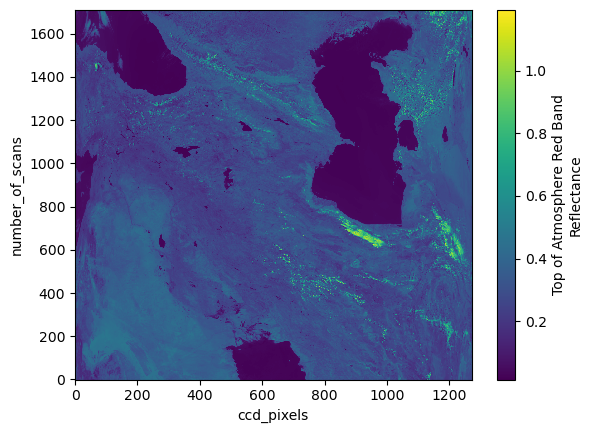

In [9]:
dataset = xr.open_dataset(l2gen_ifile, group="observation_data")
artist = dataset["rhot_red"].sel({"red_bands": 100}).plot()

[back to top](#Contents)

## 3. Process L1B Data with `l2gen`

At Level-1, we neither have geophysical variables nor are the data projected for easy map making. We will need to process the L1B file to Level-2 and then to Level-3 to get both of those. Note that Level-2 data for many geophysical variables are available for download from the OB.DAAC, so you often don't need the first step. However, the Level-3 data distributed by the OB.DAAC are global composites, which may cover more Level-2 scenes than you want. You'll learn more about compositing below. `l2gen` also allows you to customize products in a way that allows you to get products you cannot directly download from earthdata, like you will see from the following two examples. The first shows how to produce surface reflectances to make true-color images. The second covers the upcoming MOANA phytoplankton community composition products. 

This section shows how to use `l2gen` for processing the L1B data to L2 using customizable parameters. 

<div class="alert alert-warning">

OCSSW programs are run from the command line in Bash, but we can have a Bash terminal-in-a-cell using the [IPython magic][magic] command `%%bash`. In the specific case of OCSSW programs, the Bash environment created for that cell must be set up by loading `$OCSSWROOT/OCSSW_bash.env`.

</div>

Every `%%bash` cell that calls an OCSSW program needs to `source` the environment
definition file shipped with OCSSW, because its effects are not retained from one cell to the next.
We can, however, define the `OCSSWROOT` environment variable in a way that effects every `%%bash` cell.

[magic]: https://ipython.readthedocs.io/en/stable/interactive/magics.html#built-in-magic-commands

In [10]:
os.environ.setdefault("OCSSWROOT", "/opt/ocssw")

'/opt/ocssw'

Then we need a couple lines, which will appear in multiple cells below, to begin a Bash cell initiated with the `OCSSW_bash.env` file.

Using this pattern, run the `l2gen` command with the single argument `help` to view the extensive list of options available. You can find more information about `l2gen` and other OCSSW functions on the [seadas website](https://seadas.gsfc.nasa.gov/help-8.3.0/processors/ProcessL2gen.html)

In [11]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen help

msl12 9.7.0-V2024.1 (Jul 17 2024 13:15:09)


Usage: msl12 argument-list


  The argument-list is a set of keyword=value pairs. The arguments can


  be specified on the commandline, or put into a parameter file, or the


  two methods can be used together, with commandline over-riding.


  return value: 0=OK, 1=error, 110=north,south,east,west does not intersect


  file data.


The list of valid keywords follows:


   help (boolean) (alias=h) (default=false) = print usage information


   version (boolean) (default=false) = print the version


        information


   dump_options (boolean) (default=false) = print


        information about each option


   dump_options_paramfile (ofile) = print


        information about each option to paramfile


   dump_options_xmlfile (ofile) = print


        information about each option to XML file


   par (ifile) = input parameter file


   pversion (string) (default=Unspecified) = processing version string


   suite (string) (default=OC) = product suite string for loading


        suite-specific defaults


   eval (int) (default=0) = evaluation bitmask


          0: standard processing


          1: init to old aerosol models


          2: enables MODIS and MERIS cloud Mask for HABS


         16: enables MODIS cirrus mask


         32: use test sensor info file


         64: use test rayleigh tables


        128: use test aerosol tables


        256: use test polarization tables


       1024: mask modis mirror-side 1 (navfail)


       2048: mask modis mirror-side 2 (navfail)


       4096: don't apply 'cold-only' or equatorial aerosol tests for SST


       8192: use alt sensor info file in eval


      32768: enables spherical path geom for dtran


   ifile (ifile) (alias=ifile1) = input L1 file name


   ilist (ifile) = file containing list of input files, one per line


   geofile (ifile) = input L1 geolocation file name (MODIS/VIIRS only)


   ofile (ofile) (alias=ofile1) (default=output) = output file #1 name,


        output vicarious L1B for inverse mode


   ofile[#] = additional output L2 file name


   oformat (string) (default=netCDF4) = output file format


        netcdf4: output a netCDF version 4 file


        hdf4:    output a HDF version 4 file


   il2file (ifile) (alias=il2file1) = input L2 file names for sensor to be


        used as a calibrator.  Alternatively, a data point can be used as a


        calibrator (e.g. MOBY)


   il2file[#] = additional L2 calibration file names


   tgtfile (ifile) = vicarious calibration target file


   aerfile (ifile) = aerosol model specification file


   metafile (ifile) = output meta-data file


   l2prod (string) (alias=l2prod1) = L2 products to be included in ofile #1


   l2prod[#] = L2 products to be included in ofile[#]


   proc_ocean (int) (default=1) = toggle ocean processing


        1: On


        0: Off


        2: force all pixels to be processed as ocean


   proc_land (boolean) (default=off) = toggle land processing


   proc_sst (boolean) (default=false) = toggle SST processing


        (default=1 for MODIS, 0 otherwise)


   proc_cloud (boolean) (default=off) = toggle cloud processing


   proc_uncertainty (int) (default=0) = uncertainty propagation mode


        0: without uncertainty propagation


        1: uncertainty propagation generating error variance


   atmocor (boolean) (default=on) = toggle atmospheric correction


   mode (int) (default=0) = processing mode


        0: forward processing


        1: inverse (calibration) mode, targeting to nLw=0


        2: inverse (calibration) mode, given nLw target


        3: inverse (calibration) mode, given Lw target (internally normalized)


   aer_opt (int) (default=99) = aerosol mode option


      -99: No aerosol subtraction


      >0: Multi-scattering with fixed model (provide model number, 1-N,


           relative to aermodels list)


        0: White aerosol extrapolation.


       -1: Multi-scattering with 2-band model selection


       -2: Multi-scattering with 2-band, RH-based model selection and


           iterative NIR correction


       -3: Multi-scattering with 2-band model selection


           and iterative NIR correction


       -4: Multi-scattering with fixed model pair


           (requires aermodmin, aermodmax, aermodrat specification)


       -5: Multi-scattering with fixed model pair


           and iterative NIR correction


           (requires aermodmin, aermodmax, aermodrat specification)


       -6: Multi-scattering with fixed angstrom


           (requires aer_angstrom specification)


       -7: Multi-scattering with fixed angstrom


           and iterative NIR correction


           (requires aer_angstrom specification)


       -8: Multi-scattering with fixed aerosol optical thickness


           (requires taua specification)


       -9: Multi-scattering with 2-band model selection using Wang et al. 2009


           to switch between SWIR and NIR. (MODIS only, requires aer_swir_short,


           aer_swir_long, aer_wave_short, aer_wave_long)


      -10: Multi-scattering with MUMM correction


           and MUMM NIR calculation


      -17: Multi-scattering epsilon, RH-based model selection


           and iterative NIR correction


      -18: Spectral Matching of aerosols reflectance


           and iterative NIR correction


      -19: Multi-scattering epsilon (linear), RH-based model selection


           and iterative NIR correction


   aer_wave_short (int) (default=765) = shortest sensor wavelength for aerosol


        model selection


   aer_wave_long (int) (default=865) = longest sensor wavelength for aerosol


        model selection


   aer_wave_base (int) (default=865) = base sensor wavelength for aerosol 


         extrapolation


   aer_swir_short (int) (default=-1) = shortest sensor wavelength for


        SWIR-based NIR Lw correction


   aer_swir_long (int) (default=-1) = longest sensor wavelength for SWIR-based


        NIR Lw correction


   aer_rrs_short (float) (default=-1.0) = Rrs at shortest sensor wavelength for


        aerosol model selection


   aer_rrs_long (float) (default=-1.0) = Rrs at longest sensor wavelength for


        aerosol model selection


   aermodmin (int) (default=-1) = lower-bounding model to use for fixed model


        pair aerosol option


   aermodmax (int) (default=-1) = upper-bounding model to use for fixed model


        pair aerosol option


   aermodrat (float) (default=0.0) = ratio to use for fixed model pair aerosol


        option


   aer_angstrom (float) (default=-999.0) = aerosol angstrom exponent for model


        selection


   aer_iter_max (int) (default=10) = maximum number of iterations for NIR


        water-leaving radiance estimation.


   mumm_alpha (float) (default=1.72) = water-leaving reflectance ratio for MUMM


       turbid water atmospheric correction


   mumm_gamma (float) (default=1.0) = two-way Rayleigh-aerosol transmittance


       ratio for MUMM turbid water atmospheric correction


   mumm_epsilon (float) (default=1.0) = aerosol reflectance ratio for MUMM


        turbid water atmospheric correction


   absaer_opt (int) (default=0) = absorbing aerosol flagging option


        0: disabled


        1: use rhow_412 aerosol index test


        2: GMAO ancillary aerosol test


   glint_opt (int) (default=1) = glint correction:


        0: glint correction off


        1: standard glint correction


        2: simple glint correction


   oxaband_opt (int) (default=0) = oxygen A-band correction


        0: no correction


        1: Apply Ding and Gordon (1995) correction


        2: Apply oxygen transmittance from gas transmittance table (see gas_opt)


   cirrus_opt (boolean) (default=false) = cirrus cloud reflectance correction option


   filter_opt (boolean) (default=false) = filtering input data option


   filter_file (ifile) (default=$OCDATAROOT/sensor/sensor_filter.dat) = 


        data file for input filtering


   brdf_opt (int) (default=0) = Bidirectional reflectance correction


        0: no correction


        1: Fresnel reflection/refraction correction for sensor path


        3: Fresnel reflection/refraction correction for sensor + solar path


        7: Morel f/Q + Fresnel solar + Fresnel sensor


       15: Gordon DT + Morel f/Q + Fresnel solar + Fresnel sensor


       19: Morel Q + Fresnel solar + Fresnel sensor


   fqfile (ifile) (default=$OCDATAROOT/common/morel_fq.nc) = f/Q correction file


   parfile (ifile) = par climatology file for NPP calculation


   gas_opt (int) (default=1) = gaseous transmittance bitmask selector


        0: no correction


        1: Ozone


        2: CO2


        4: NO2


        8: H2O


       16: Use ATREM


       32: Use <sensor>_gas_transmittance.nc tables


       64: CO


      128: CH4


      256: N2O


   atrem_opt (int) (default=0) = ATREM gaseous transmittance bitmask selector


        0: H2O only


        1: Ozone


        2: CO2


        4: NO2


        8: CO


       16: CH4


       32: O2


       64: N2O 


   atrem_full (int) (default=0) = ATREM gaseous transmittance calculation option


        0: Calculate transmittance using k-distribution method (fast)


        1: Calculate transmittance using full method (slow)


   atrem_geom (int) (default=0) = ATREM gaseous transmittance geometry option


        0: Only recalculate geometry when error threshold reached (fast)


        1: Recalculate geometry every pixel (slow)


   atrem_model (int) (default=0) = ATREM gaseous transmittance Atm. model selection


        0: Use pixel's latitude and date to determine model 


        1: tropical


        2: mid latitude summer


        3: mid latitude winter


        4: subarctic summer


        5: subarctic winter


        6: US standard 1962


   atrem_splitpaths (int) (default=0) = ATREM gaseous transmittance split paths between solar and sensor (turns atrem_full on)


        0: Calculates transmittance over total path length (default)


        1: Calculates transmittance over separate solar and sensor paths (slow)


   iop_opt (int) (default=0) = IOP model for use in downstream products


        0: None (products requiring a or bb will fail)


        1: Carder


        2: GSM


        3: QAA


        4: PML


        5: NIWA


        6: LAS


        7: GIOP


   cphyt_opt (int) (default=1) = model for phytoplankton carbon


        1: Graff/Westberry


        2: Behrenfeld


   seawater_opt (int) (default=0) = seawater IOP options


        0: static values


        1: temperature & salinity-dependent seawater nw, aw, bbw


   polfile (ifile) = polarization sensitivities filename leader


   pol_opt (int) (default=-1) = polarization correction (sensor-specific)


        0: no correction


        1: only Rayleigh component is polarized


        2: all radiance polarized like Rayleigh


        3: only Rayleigh and Glint are polarized (MODIS default)


        4: all radiance polarized like Rayleigh + Glint


   band_shift_opt (int) (default=0) = bandshifting option 


        1: apply bio-optical bandshift


        0: linear interpolation


   giop_aph_opt (int) (default=2) = GIOP model aph function type


        0: tabulated (supplied via giop_aph_file)


        2: Bricaud et al. 1995 (chlorophyll supplied via default empirical algorithm)


        3: Ciotti and Bricaud 2006 (size fraction supplied via giop_aph_s)


   giop_aph_file (ifile) (default=$OCDATAROOT/common/aph_default.txt) = 


        GIOP model, tabulated aph spectra


   giop_uaph_file (ifile) (default=$OCDATAROOT/common/aph_unc_default.txt) = 


        GIOP model, tabulated aph uncertainty spectra


   giop_aph_s (float) (default=-1000.0) = GIOP model, spectral parameter


        for aph


   giop_adg_opt (int) (default=1) = GIOP model adg function type


        0: tabulated (supplied via giop_adg_file)


        1: exponential with exponent supplied via giop_adg_s)


        2: exponential with exponent derived via Lee et al. (2002)


        3: exponential with exponent derived via OBPG method


   giop_adg_file (string) (default=$OCDATAROOT/common/adg_default.txt) = 


        GIOP model, tabulated adg spectra


   giop_uadg_file (ifile) (default=$OCDATAROOT/common/adg_unc_default.txt) = 


        GIOP model, tabulated adg uncertainty spectra


   giop_adg_s (float) (default=0.018) = GIOP model, spectral parameter


        for adg


   giop_uadg_s (float) (default=0.0) = GIOP model, uncertainty of spectral


         parameter for adg


   giop_bbp_opt (int) (default=3) = GIOP model bbp function type


        0: tabulated (supplied via giop_bbp_file)


        1: power-law with exponent supplied via giop_bbp_s)


        2: power-law with exponent derived via Hoge & Lyon (1996)


        3: power-law with exponent derived via Lee et al. (2002)


        5: power-law with exponent derived via Ciotti et al. (1999)


        6: power-law with exponent derived via Morel & Maritorena (2001)


        7: power-law with exponent derived via Loisel & Stramski (2000)


        8: spectrally independent vector derived via Loisel & Stramski (2000)


        9: fixed vector derived via Loisel & Stramski (2000)


       10: fixed vector derived via lee et al. (2002)


       11: fixed vector derived via McKinna et al. (2021)


       12: fixed vector derived via Huot et al. (2008)


   giop_bbp_file (ifile) (default=$OCDATAROOT/common/bbp_default.txt) = 


        GIOP model, tabulated bbp spectra


   giop_ubbp_file (ifile) (default=$OCDATAROOT/common/bbp_default.txt) = 


         GIOP model, tabulated bbp uncertainty spectra


   giop_bbp_s (float) (default=-1000.0) = GIOP model, spectral parameter


        for bbp


   giop_ubbp_s (float) (default=0.0) = GIOP model, uncertainty in spectral


        parameter for bbp


   giop_acdom_opt (int) (default=1) = GIOP model acdom function type


        0: tabulated (supplied via giop_acdom_file)


        1: no data


   giop_acdom_file (ifile) = 


        GIOP model, file of specific CDOM absorption coefficients for aLMI


   giop_uacdom_file (ifile) = 


        GIOP model, file of specific CDOM absorption uncertainties for aLMI


   giop_anap_opt (int) (default=1) = GIOP model anap function type


        0: tabulated (supplied via giop_anap_file)


        1: no data


   giop_anap_file (ifile) = 


        GIOP model, file of specific NAP absorption coefficients for aLMI


   giop_uanap_file (ifile) = 


       GIOP model, file of specific NAP absorption coefficient uncertainties for aLMI


   giop_bbph_opt (int) (default=1) = GIOP model bbph function type


        0: tabulated (supplied via giop_bbph_file)


        1: no data


   giop_bbph_file (ifile) = 


        GIOP model, file of specific phytoplankton backscattering coefficients for aLMI


   giop_ubbph_file (ifile) = 


       GIOP model, file of specific phytoplankton backscatteirng coefficient uncertainties for aLMI


   giop_bbnap_opt (int) (default=1) = GIOP model bbnap function type


        0: tabulated (supplied via giop_bbnap_file)


        1: no data


   giop_bbnap_file (ifile) = 


        GIOP model, file of specific NAP backscattering coefficients for aLMI


   giop_ubbnap_file (ifile) = 


       GIOP model, file of specific NAP backscattering coefficient uncertainties for aLMI


   giop_rrs_opt (int) (default=0) = GIOP model Rrs to bb/(a+bb) method


        0: Gordon quadratic (specified with giop_grd)


        1: Morel f/Q


   giop_rrs_unc_opt (int) (default=0) = GIOP model Rrs uncertainties option


        0: none 


        1: sensor-derived Rrs uncertainties 


        2: input spectral absolute uncertainties using giop_rrs_unc, as comma-separated


                array with spectral resolution matching sensor


        3: input spectral relative uncertainties using giop_rrs_unc, as comma-separated


                 array with spectral resolution matching sensor


   giop_rrs_diff (float) (default=0.33) = GIOP model, maximum difference between input and modeled Rrs


   giop_grd (float) (default=[0.0949,0.0794]) = GIOP model, Gordon


        Rrs to bb/(a+bb) quadratic coefficients


   giop_wave (float) (default=-1) = GIOP model list of sensor wavelengths for


        optimization comma-separated list, default is all visible bands (400-700nm)


   giop_maxiter (int) (default=50) = GIOP Model iteration limit


   giop_fit_opt (int) (default=1) = GIOP model optimization method


        0: Amoeba optimization


        1: Levenberg-Marquardt optimization


        3: SVD matrix inversion


        4: SIOP adaptive matrix inversion


   gsm_opt (int) (default=0) = GSM model options


        0: default coefficients


        1: Chesapeake regional coefficients


   gsm_fit (int) (default=0) = GSM fit algorithm


        0: Amoeba


        1: Levenberg-Marquardt


   gsm_adg_s (float) (default=0.02061) = GSM IOP model, spectral slope for adg


   gsm_bbp_s (float) (default=1.03373) = GSM IOP model, spectral slope for bbp


   gsm_aphw (float) (default=[412.0, 443.0, 490.0, 510.0, 555.0, 670.0]) = 


        GSM IOP model, wavelengths of ap* table


   gsm_aphs (float) (default=[0.00665, 0.05582, 0.02055, 0.01910, 0.01015, 0.01424]) = GSM IOP model, coefficients of ap* table


   qaa_adg_s (float) (alias=qaa_S) (default=0.015) = QAA IOP model, spectral


        slope for adg


   qaa_wave (int) = sensor wavelengths for QAA algorithm


   chloc2_wave (int) (default=[-1,-1]) = sensor wavelengths for OC2 chlorophyll


        algorithm


   chloc2_coef (float) (default=[0.0,0.0,0.0,0.0,0.0]) = coefficients for OC2


        chlorophyll algorithm


   chloc3_wave (int) (default=[-1,-1,-1]) = sensor wavelengths for OC3


         chlorophyll algorithm


   chloc3_coef (float) (default=[0.0,0.0,0.0,0.0,0.0]) = coefficients for OC3


        chlorophyll algorithm


   chloc4_wave (int) (default=[-1,-1,-1,-1]) = sensor wavelengths for OC4


        chlorophyll algorithm


   chloc4_coef (float) (default=[0.0,0.0,0.0,0.0,0.0]) = coefficients for OC4


        chlorophyll algorithm


   kd2_wave (int) (default=[-1,-1]) = sensor wavelengths for polynomial Kd(490)


        algorithm


   kd2_coef (float) (default=[0.0,0.0,0.0,0.0,0.0,0.0]) = sensor wavelengths


        for polynomial Kd(490) algorithm


   flh_offset (float) (default=0.0) = bias to subtract


        from retrieved fluorescence line height


   vcnnfile (ifile) = virtual constellation neural net file


   picfile (ifile) = pic table for Balch 2-band algorithm


   owtfile (ifile) = optical water type file


   owtchlerrfile (ifile) = chl error file associate with optical water type


   aermodfile (ifile) = aerosol model filename leader


   uncertaintyfile (ifile) = uncertainty LUT


   aermodels (string) (default=[r30f95v01,r30f80v01,r30f50v01,r30f30v01,r30f20v01,r30f10v01,r30f05v01,r30f02v01,r30f01v01,r30f00v01,r50f95v01,r50f80v01,r50f50v01,r50f30v01,r50f20v01,r50f10v01,r50f05v01,r50f02v01,r50f01v01,r50f00v01,r70f95v01,r70f80v01,r70f50v01,r70f30v01,r70f20v01,r70f10v01,r70f05v01,r70f02v01,r70f01v01,r70f00v01,r75f95v01,r75f80v01,r75f50v01,r75f30v01,r75f20v01,r75f10v01,r75f05v01,r75f02v01,r75f01v01,r75f00v01,r80f95v01,r80f80v01,r80f50v01,r80f30v01,r80f20v01,r80f10v01,r80f05v01,r80f02v01,r80f01v01,r80f00v01,r85f95v01,r85f80v01,r85f50v01,r85f30v01,r85f20v01,r85f10v01,r85f05v01,r85f02v01,r85f01v01,r85f00v01,r90f95v01,r90f80v01,r90f50v01,r90f30v01,r90f20v01,r90f10v01,r90f05v01,r90f02v01,r90f01v01,r90f00v01,r95f95v01,r95f80v01,r95f50v01,r95f30v01,r95f20v01,r95f10v01,r95f05v01,r95f02v01,r95f01v01,r95f00v01]) = aerosol models


   met1 (ifile) (default=$OCDATAROOT/common/met_climatology.hdf) = 


        1st meteorological ancillary data file


   met2 (ifile) = 2nd meteorological ancillary data file


   met3 (ifile) = 3rd meteorological ancillary data file


   ozone1 (ifile) (default=$OCDATAROOT/common/ozone_climatology.hdf) = 


        1st ozone ancillary data file


   ozone2 (ifile) = 2nd ozone ancillary data file


   ozone3 (ifile) = 3rd ozone ancillary data file


   rad1 (ifile) = Ancillary data for PAR, 1st file


   rad2 (ifile) = Ancillary data for PAR, 2nd file


   rad3 (ifile) = Ancillary data for PAR, 3rd file


   anc_profile1 (ifile) = 


        1st ancillary profile data file


   anc_profile2 (ifile) = 


        2nd ancillary profile data file


   anc_profile3 (ifile) = 


        3rd ancillary profile data file


   anc_aerosol1 (ifile) = 


        1st ancillary aerosol data file


   anc_aerosol2 (ifile) = 


        2nd ancillary aerosol data file


   anc_aerosol3 (ifile) = 


        3rd ancillary aerosol data file


   sfc_albedo (ifile) = 


        ancillary cloud albedo data file


   cth_albedo (ifile) = 


        ancillary albedo file for cloud top height use


   anc_cor_file (ifile) = ozone correction file


   pixel_anc_file (ifile) = per pixel ancillary data file


   land (ifile) (default=$OCDATAROOT/common/gebco_ocssw_v2020.nc) = land mask file


   water (ifile) (default=$OCDATAROOT/common/gebco_ocssw_v2020.nc) = 


        shallow water mask file


   demfile (ifile) (default=$OCDATAROOT/common/gebco_ocssw_v2020.nc) = 


        digital elevation map file


   dem_auxfile (ifile) = auxiliary digital elevation map file


   mldfile (ifile) = Multi-layer depth file


   icefile (ifile) (default=$OCDATAROOT/common/ice_mask.hdf) = sea ice file


   ice_threshold (float) (default=0.1) = sea ice fraction above which will be


        flagged as sea ice


   sstcoeffile (ifile) = IR sst algorithm coefficients file


   dsdicoeffile (ifile) = SST dust correction algorithm coefficients file


   sstssesfile (ifile) = IR sst algorithm error statistics file


   sst4coeffile (ifile) = SWIR sst algorithm coefficients file


   sst4ssesfile (ifile) = SWIR sst algorithm error statistics file


   sst3coeffile (ifile) = Triple window sst algorithm coefficients file


   sst3ssesfile (ifile) = Triple window sst algorithm error statistics file


   sstfile (ifile) (default=$OCDATAROOT/common/sst_climatology.hdf) = input


        SST reference file


   sstreftype (int) (default=0) = Reference SST field source


        0: Reynolds OI SST reference file


        1: AMSR-E daily SST reference file


        2: AMSR-E 3-day SST reference file


        3: ATSR monthly SST reference file


        4: NTEV2 monthly SST reference file


        5: AMSR-E 3-day or night SST reference file


        6: WindSat daily SST reference file


        7: WindSat 3-day SST reference file


        8: WindSat 3-day or night SST reference file


   sstrefdif (float) (default=100.0) = stricter sst-ref difference threshold


   viirsnv7 (int) (default=-1) = =1 to use the VIIRSN V7 high senz latband sst and sst3 equations


   viirsnosisaf (int) (default=0) = =1 to use the VIIRSN OSI-SAF sst and sst3 equations


   no2file (ifile) (default=$OCDATAROOT/common/no2_climatology.hdf) = no2


        ancillary file


   alphafile (ifile) (default=$OCDATAROOT/common/alpha510_climatology.hdf) = 


        alpha510 climatology file


   tauafile (ifile) (default=$OCDATAROOT/common/taua865_climatology.hdf) = 


        taua865 climatology file


   flaguse (string) (default=ATMFAIL,LAND,HIGLINT,HILT,HISATZEN,STRAYLIGHT,CLDICE,COCCOLITH,LOWLW,CHLFAIL,NAVWARN,ABSAER,MAXAERITER,ATMWARN,HISOLZEN,NAVFAIL) = Flags to use


   xcalbox (int) (default=0) = pixel size of the central box in the L1 scene


        (e.g. 5 pixels around MOBY) to be extracted into xcalfile for the


        cross-calibration, 0=whole L1


   xcalboxcenter (int) (default=[0,0]) = Central [ipix, iscan] of the box in


        the L1 scene, [0,0] = center of the L1 scene


   xcalpervalid (int) (default=0) = min percent of valid cross-calibration


        pixels within the box or the L1 scene, 0 = at least 1 pixel


   xcalsubsmpl (int) (default=1) = Sub-sampling rate for the data to be used


        for the cross-calibration


   chlthreshold (float) (default=100.000000) = threshold on L2 data chlorophyll


        (100.000000=CHL_MAX)


   aotthreshold (float) (default=1.000000) = threshold on L2 data AOTs


        (1.000000=AOT_MAX)


   coccolith (float) (default=[1.1,0.9,0.75,1.85,1.0,1.65,0.6,1.15]) = 


        coccolithophore algorithm coefs


   cirrus_thresh (float) (default=[-1.0,-1.0]) = cirrus reflectance thresholds


   taua (float) = [taua_band1,...,taua_bandn] aerosol optical thickness of the


        calibration data point


   absaer (float) (default=0.0) = absorbing aerosol threshold on aerosol index


   rhoamin (float) (default=0.0001) = min NIR aerosol reflectance to attempt


        model lookup


   epsmin (float) (default=0.85) = minimum epsilon to trigger atmospheric


        correction failure flag


   epsmax (float) (default=1.35) = maximum epsilon to trigger atmospheric


         correction failure flag


   tauamax (float) (default=0.3) = maximum 865 aerosol optical depth to trigger


        hitau flag


   nLwmin (float) (default=0.15) = minimum nLw(555) to trigger low Lw flag


   wsmax (float) (default=12.0) = windspeed limit on white-cap correction in m/s


   windspeed (float) (default=-1000.0) = user over-ride of windspeed in m/s


        (-1000=use ancillary files)


   windangle (float) (default=-1000.0) = user over-ride of wind angle in deg


        (-1000=use ancillary files)


   pressure (float) (default=-1000.0) = user over-ride of atmospheric pressure


        in mb (-1000=use ancillary files)


   ozone (float) (default=-1000.0) = user over-ride of ozone concentration in


        cm (-1000=use ancillary files)


   relhumid (float) (default=-1000.0) = user over-ride of relative humidity in


        percent (-1000=use ancillary files)


   watervapor (float) (default=-1000.0) = user over-ride of water vapor in


        g/cm^2 (-1000=use ancillary files)


   vcal_opt (int) (default=-1) = Vicarious calibration option


   vcal_chl (float) (default=-1.0) = Vicarious calibration chl


   vcal_solz (float) (default=-1.0) = Vicarious calibration solz


   vcal_nLw (float) = Vicarious calibration normalized water leaving radiances


   vcal_Lw (float) = Vicarious calibration water leaving radiances


   vcal_depth (float) (default=-1000.0) = depth to use to exclude data from target file


   e.g. -1000 excludes depths less than 1000m


   vcal_min_nbin (int) (default=4) = minimum # of samples in a bin for acceptance


   vcal_min_nscene (int) (default=3) = minimum # of scenes in a bin for acceptance


   owmcfile (ifile) (default=$OCDATAROOT/common/owmc_lut.hdf) = lut for OWMC


        classification


   north (float) (default=-999) = north boundary


   south (float) (default=-999) = south boundary


   east (float) (default=-999) = east boundary


   west (float) (default=-999) = west boundary


   xbox (int) (default=-1) = number of pixels on either side of the SW point


   ybox (int) (default=-1) = number of scan lines on either side of the SW point


   subsamp (int) (default=1) = sub-sampling interval


   prodxmlfile (ofile) = output XML file describing all possible products


   breflectfile (ifile) = input NetCDF file for bottom reflectances and bottom types


   bpar_validate_opt (int) (default=0) = use solar noon(0), use sensor overpass (1)


   bpar_elev_opt (int) (default=0) = use bathymery (0), user-defined geometric depth (1) 


   bpar_elev_value (float) (default=30.0) = user defined bpar geometric depth value


   deflate (int) (default=0) = deflation level


   raman_opt (int) (default=0) = Raman scattering Rrs correction options


        0: no correction 


        1: Lee et al. (2013) empirical correction 


        2: Westberry et al. (2013) analytical correction 


        3: Lee et al. (1994) analytical correction


   gmpfile (ifile) = GMP geometric parameter file (MISR only)


   water_spectra_file (ifile) = water absorption/scattering coefficient file


   shallow_water_depth (float) (default=30.0) = threshold for flagging shallow water


   avw_coef (float) (default=[0.0,0.0,0.0,0.0,0.0,0.0]) = coefficients for AVW


   cloud_hgt_file (ifile) = Cloud height and temperature file


     Currently, use the MODIS L2 cloud file (MYD06...)


     from the LAADS DAAC


   doi (string) = Digital Object Identifier (DOI) string


   wavelength_3d (string) = wavelength_3d input, written in ascending order


        with format 'wavelength_3d=nnn,nnn,nnn' where nnn is a sensor wavelength


        or a range of wavelengths as follows 'nnn:nnn'


   mbac_wave (int) = bands used for mbac atmospheric correction


   calfile (ifile) = system calibration file


   rad_opt (int) (default=0) = radiation correction option (sensor-specific)


        0: no correction


        1: apply MERIS Smile correction


   viirscalparfile (ifile) = VIIRS L1A calibration parameter file name (VIIRS only)


   geom_per_band (boolean) (default=0) = geometry per band option:


        0: use nominal viewing geometry - same for all bands


        1: use band-specific viewing geometry (if available)


   xcalfile (ifile) = cross-calibration file


   xcal_opt (int) = cross-calibration option (sensor-specific) comma separated


        list of option values, 1 per band, with bands listed in xcal_wave.


        3: apply cross-calibration corrections (polarization and rvs)


        2: apply cross-calibration polarization corrections


        1: apply cross-calibration rvs corrections


        0: no correction


   xcal_wave (float) = wavelengths at which to apply cross-calibration.  Comma


        separated list of sensor wavelength values associated with xcal_opt.


   resolution (int) (default=-1) = processing resolution (MODIS only)


       -1: standard ocean 1km processing


     1000: 1km resolution including aggregated 250 and 500m land bands


      500: 500m resolution including aggregated 250 land bands and


           replication for lower resolution bands


      250: 250m resolution with replication for lower resolution bands


   newavhrrcal (int) (default=0) = =1 for new noaa-16 calibration


   ch22detcor (float) (default=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) = 


        Channel 22 detector corrections (MODIS only)


   ch23detcor (float) (default=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) = 


        Channel 23 detector corrections (MODIS only)


   sl_pixl (int) (default=-1) = SeaWiFS only, number of LAC pixels for


        straylight flagging


   sl_frac (float) (default=0.25) = SeaWiFS only, straylight fractional


        threshold on Ltypical


   outband_opt (int) (default=99) = out-of-band correction for water-leaving


        radiances


        2: On (default for MODIS, SeaWiFS, OCTS)


        0: Off (default for MOS, OSMI)


   maskland (boolean) (default=on) = land mask option


   maskbath (boolean) (default=off) = shallow water mask option


   maskcloud (boolean) (default=on) = cloud mask option


   maskglint (boolean) (default=off) = glint mask option


   masksunzen (boolean) (default=off) = large sun zenith angle mask option


   masksatzen (boolean) (default=off) = large satellite zenith angle mask option


   maskhilt (boolean) (default=on) = high Lt masking


   maskstlight (boolean) (default=on) = stray light masking


   sunzen (float) (default=75.0) = sun zenith angle threshold in deg.


   satzen (float) (default=60.0) = satellite zenith angle threshold


   hipol (float) (default=0.5) = threshold on degree-of-polarization to set


        HIPOL flag


   glint_thresh (float) (alias=glint) (default=0.005) = high sun glint threshold


   cloud_thresh (float) (alias=albedo) (default=0.027) = cloud reflectance


        threshold


   cloud_wave (float) (default=865.0) = wavelength of cloud reflectance test


   cloud_eps (float) (default=-1.0) = cloud reflectance ratio threshold


        (-1.0=disabled)


   cloud_mask_file (ifile) = cloud mask file


   cloud_mask_opt (int) (default=0) = cloud mask file variable name


          0: cloud_flag


          1: cloud_flag_dilated


   offset (float) = calibration offset adjustment


   gain (float) = calibration gain multiplier


   spixl (int) (default=1) = start pixel number


   epixl (int) (default=-1) = end pixel number (-1=the last pixel)


   dpixl (int) (default=1) = pixel sub-sampling interval


   sline (int) (default=1) = start line number


   eline (int) (default=-1) = end line number (-1=the last line)


   dline (int) (default=1) = line sub-sampling interval


   georegion_file (string) = geo region mask file with lat,lon,georegion 1=process pixel, 0=do not


To process a L1B file using `l2gen`, at a minimum, you need to set an infile name (`ifile`) and an outfile name (`ofile`). You can also indicate a data suite; in this example, we will proceed with the biogeochemical (BGC) suite that includes chlorophyll *a* estimates.

Parameters can be passed to OCSSW programs through a text file. They can also be passed as arguments, but writing to a text file leaves a clear processing record. Define the parameters in a dictionary, then send it to the `write_par` function
defined in the [Setup](#1.-Setup) section.

In [12]:
par = {
    "ifile": l2gen_ifile,
    "ofile": str(l2gen_ifile).replace(".L1B.", ".L2_SFREFL."),
    "suite": "SFREFL",
    "atmocor": 0,
}
write_par("l2gen.par", par)

With the parameter file ready, it's time to call `l2gen` from a `%%bash` cell. 

In [13]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen par=l2gen.par

Loading default parameters from /opt/ocssw/share/common/msl12_defaults.par


Input file data/PACE_OCI.20240605T092137.L1B.V2.nc is PACE L1B file.


Loading characteristics for OCI


Opening sensor information file /opt/ocssw/share/oci/msl12_sensor_info.dat


  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw


    0  314.550  112.026 4.873e-01 4.208e-01 3.281e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03


    1  316.239   92.478 6.485e-01 5.806e-01 2.961e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03


    2  318.262   85.195 7.410e-01 5.473e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03


    3  320.303   82.175 7.809e-01 4.609e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03


    4  322.433   80.733 7.906e-01 3.543e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03


    5  324.649   86.251 7.915e-01 2.567e-01 3.018e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03


    6  326.828   95.932 7.891e-01 1.907e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03


    7  328.988  101.672 7.700e-01 1.386e-01 3.251e-19 1.000e+00 0.000e+00 8.211e-02 7.627e-03


    8  331.305  101.708 7.404e-01 9.852e-02 3.417e-19 1.000e+00 0.000e+00 8.089e-02 7.342e-03


    9  333.958   97.745 7.204e-01 6.830e-02 3.572e-19 1.000e+00 0.000e+00 7.656e-02 7.132e-03


   10  336.815   93.497 7.112e-01 4.395e-02 3.736e-19 1.000e+00 0.000e+00 6.891e-02 6.975e-03


   11  339.160   96.099 7.034e-01 3.070e-02 3.963e-19 1.000e+00 0.000e+00 6.288e-02 6.834e-03


   12  341.321   98.332 6.898e-01 2.060e-02 4.076e-19 1.000e+00 0.000e+00 5.915e-02 6.663e-03


   13  343.632   95.167 6.720e-01 1.439e-02 4.137e-19 1.000e+00 0.000e+00 5.624e-02 6.474e-03


   14  346.017   92.958 6.529e-01 9.882e-03 4.395e-19 1.000e+00 0.000e+00 5.365e-02 6.285e-03


   15  348.468   95.422 6.342e-01 6.032e-03 4.610e-19 1.000e+00 0.000e+00 5.106e-02 6.097e-03


   16  350.912   99.423 6.163e-01 4.542e-03 4.617e-19 1.000e+00 0.000e+00 4.864e-02 5.913e-03


   17  353.344  102.927 5.988e-01 3.473e-03 4.768e-19 1.000e+00 0.000e+00 4.647e-02 5.735e-03


   18  355.782   99.180 5.823e-01 2.499e-03 5.019e-19 1.000e+00 0.000e+00 4.450e-02 5.562e-03


   19  358.235   93.459 5.642e-01 2.283e-03 5.089e-19 1.000e+00 0.000e+00 4.256e-02 5.394e-03


   20  360.695   97.255 5.472e-01 2.096e-03 5.117e-19 1.000e+00 0.000e+00 4.053e-02 5.233e-03


   21  363.137  105.330 5.320e-01 1.734e-03 5.326e-19 1.000e+00 0.000e+00 3.856e-02 5.079e-03


   22  365.610  113.914 5.178e-01 1.415e-03 5.533e-19 1.000e+00 0.000e+00 3.642e-02 4.932e-03


   23  368.083  118.845 5.043e-01 1.282e-03 5.555e-19 1.000e+00 0.000e+00 3.417e-02 4.789e-03


   24  370.534  115.549 4.908e-01 1.286e-03 5.590e-19 1.000e+00 0.000e+00 3.126e-02 4.651e-03


   25  372.991  107.218 4.773e-01 1.342e-03 5.744e-19 1.000e+00 0.000e+00 2.719e-02 4.520e-03


   26  375.482  108.880 4.630e-01 1.283e-03 5.834e-19 1.000e+00 0.000e+00 2.270e-02 4.392e-03


   27  377.926  118.137 4.513e-01 1.115e-03 5.861e-19 1.000e+00 0.000e+00 1.843e-02 4.269e-03


   28  380.419  111.060 4.406e-01 1.167e-03 5.945e-19 1.000e+00 0.000e+00 1.508e-02 4.151e-03


   29  382.876   96.370 4.280e-01 1.379e-03 6.014e-19 1.000e+00 0.000e+00 1.316e-02 4.037e-03


   30  385.359   96.688 4.156e-01 1.389e-03 6.039e-19 1.000e+00 0.000e+00 1.228e-02 3.928e-03


   31  387.811  107.161 4.051e-01 1.257e-03 6.130e-19 1.000e+00 0.000e+00 1.166e-02 3.822e-03


   32  390.297  112.501 3.955e-01 1.196e-03 6.227e-19 1.000e+00 0.000e+00 1.104e-02 3.718e-03


   33  392.764  106.686 3.857e-01 1.256e-03 6.193e-19 1.000e+00 0.000e+00 1.065e-02 3.619e-03


   34  395.238  106.058 3.747e-01 1.271e-03 6.157e-19 1.000e+00 0.000e+00 1.040e-02 3.523e-03


   35  397.706  127.304 3.647e-01 1.082e-03 6.328e-19 1.000e+00 0.000e+00 9.891e-03 3.430e-03


   36  400.178  157.144 3.564e-01 9.418e-04 6.342e-19 1.000e+00 0.000e+00 8.906e-03 3.341e-03


   37  402.654  170.763 3.486e-01 9.296e-04 6.155e-19 1.000e+00 0.000e+00 7.976e-03 3.255e-03


   38  405.127  168.889 3.400e-01 9.759e-04 6.015e-19 1.000e+00 0.000e+00 7.534e-03 3.171e-03


   39  407.605  168.988 3.314e-01 1.065e-03 6.101e-19 1.000e+00 0.000e+00 7.203e-03 3.090e-03


   40  410.074  173.399 3.233e-01 1.143e-03 6.226e-19 1.000e+00 0.000e+00 6.868e-03 3.011e-03


   41  412.557  177.268 3.155e-01 1.158e-03 6.161e-19 1.000e+00 0.000e+00 6.656e-03 2.935e-03


   42  415.025  177.759 3.079e-01 1.218e-03 5.856e-19 1.000e+00 0.000e+00 6.564e-03 2.861e-03


   43  417.512  175.925 3.004e-01 1.325e-03 5.698e-19 1.000e+00 0.000e+00 6.661e-03 2.789e-03


   44  419.988  175.156 2.932e-01 1.448e-03 5.927e-19 1.000e+00 0.000e+00 6.771e-03 2.720e-03


   45  422.453  174.012 2.863e-01 1.774e-03 6.054e-19 1.000e+00 0.000e+00 6.878e-03 2.654e-03


   46  424.940  170.766 2.796e-01 2.153e-03 5.793e-19 1.000e+00 0.000e+00 7.006e-03 2.590e-03


   47  427.398  162.027 2.732e-01 2.242e-03 5.468e-19 1.000e+00 0.000e+00 6.986e-03 2.527e-03


   48  429.885  154.088 2.664e-01 2.290e-03 5.331e-19 1.000e+00 0.000e+00 6.994e-03 2.464e-03


   49  432.379  161.564 2.597e-01 2.492e-03 5.452e-19 1.000e+00 0.000e+00 7.152e-03 2.404e-03


   50  434.869  174.172 2.539e-01 2.644e-03 5.549e-19 1.000e+00 0.000e+00 7.438e-03 2.347e-03


   51  437.351  178.115 2.482e-01 3.023e-03 5.355e-19 1.000e+00 0.000e+00 8.014e-03 2.291e-03


   52  439.828  182.229 2.424e-01 3.903e-03 4.968e-19 1.000e+00 0.000e+00 8.606e-03 2.238e-03


   53  442.327  190.795 2.368e-01 4.600e-03 4.726e-19 1.000e+00 0.000e+00 9.139e-03 2.185e-03


   54  444.811  195.628 2.315e-01 4.590e-03 4.945e-19 1.000e+00 0.000e+00 9.759e-03 2.133e-03


   55  447.309  199.848 2.261e-01 4.547e-03 5.107e-19 1.000e+00 0.000e+00 1.052e-02 2.082e-03


   56  449.795  205.764 2.211e-01 4.968e-03 4.798e-19 1.000e+00 0.000e+00 1.131e-02 2.034e-03


   57  452.280  205.708 2.162e-01 5.368e-03 4.441e-19 1.000e+00 0.000e+00 1.179e-02 1.987e-03


   58  454.769  204.450 2.114e-01 5.945e-03 4.252e-19 1.000e+00 0.000e+00 1.203e-02 1.942e-03


   59  457.262  205.953 2.067e-01 7.420e-03 4.263e-19 1.000e+00 0.000e+00 1.212e-02 1.898e-03


   60  459.757  207.117 2.022e-01 9.301e-03 4.351e-19 1.000e+00 0.000e+00 1.214e-02 1.855e-03


   61  462.252  207.870 1.977e-01 1.011e-02 4.326e-19 1.000e+00 0.000e+00 1.219e-02 1.813e-03


   62  464.737  205.886 1.935e-01 9.683e-03 4.061e-19 1.000e+00 0.000e+00 1.238e-02 1.772e-03


   63  467.244  203.675 1.893e-01 9.647e-03 3.691e-19 1.000e+00 0.000e+00 1.242e-02 1.733e-03


   64  469.729  203.713 1.852e-01 1.043e-02 3.441e-19 1.000e+00 0.000e+00 1.244e-02 1.694e-03


   65  472.202  205.281 1.812e-01 1.115e-02 3.582e-19 1.000e+00 0.000e+00 1.276e-02 1.657e-03


   66  474.700  207.058 1.774e-01 1.242e-02 3.801e-19 1.000e+00 0.000e+00 1.326e-02 1.621e-03


   67  477.189  208.385 1.736e-01 1.528e-02 3.580e-19 1.000e+00 0.000e+00 1.393e-02 1.586e-03


   68  479.689  209.553 1.700e-01 1.895e-02 3.338e-19 1.000e+00 0.000e+00 1.437e-02 1.552e-03


   69  482.183  206.590 1.665e-01 2.122e-02 3.022e-19 1.000e+00 0.000e+00 1.472e-02 1.518e-03


   70  484.689  195.340 1.631e-01 2.114e-02 2.725e-19 1.000e+00 0.000e+00 1.533e-02 1.485e-03


   71  487.182  189.524 1.595e-01 2.040e-02 2.939e-19 1.000e+00 0.000e+00 1.612e-02 1.454e-03


   72  489.674  195.470 1.562e-01 2.101e-02 3.044e-19 1.000e+00 0.000e+00 1.694e-02 1.423e-03


   73  492.176  199.211 1.530e-01 2.224e-02 2.853e-19 1.000e+00 0.000e+00 1.789e-02 1.393e-03


   74  494.686  200.274 1.499e-01 2.354e-02 2.822e-19 1.000e+00 0.000e+00 1.916e-02 1.364e-03


   75  497.182  199.355 1.469e-01 2.613e-02 2.498e-19 1.000e+00 0.000e+00 2.072e-02 1.336e-03


   76  499.688  194.720 1.440e-01 3.087e-02 2.022e-19 1.000e+00 0.000e+00 2.233e-02 1.309e-03


   77  502.190  192.753 1.410e-01 3.665e-02 2.151e-19 1.000e+00 0.000e+00 2.438e-02 1.281e-03


   78  504.695  195.557 1.382e-01 4.082e-02 2.384e-19 1.000e+00 0.000e+00 2.700e-02 1.255e-03


   79  507.198  197.605 1.355e-01 4.179e-02 2.315e-19 1.000e+00 0.000e+00 3.003e-02 1.230e-03


   80  509.720  196.520 1.328e-01 4.101e-02 2.296e-19 1.000e+00 0.000e+00 3.389e-02 1.206e-03


   81  512.213  193.098 1.302e-01 4.110e-02 2.157e-19 1.000e+00 0.000e+00 3.784e-02 1.181e-03


   82  514.729  185.769 1.277e-01 4.275e-02 1.772e-19 1.000e+00 0.000e+00 4.045e-02 1.157e-03


   83  517.219  179.326 1.252e-01 4.504e-02 1.597e-19 1.000e+00 0.000e+00 4.179e-02 1.134e-03


   84  519.747  182.521 1.227e-01 4.767e-02 1.620e-19 1.000e+00 0.000e+00 4.270e-02 1.111e-03


   85  522.249  189.089 1.203e-01 5.134e-02 1.624e-19 1.000e+00 0.000e+00 4.337e-02 1.089e-03


   86  524.771  188.823 1.180e-01 5.654e-02 1.755e-19 1.000e+00 0.000e+00 4.387e-02 1.067e-03


   87  527.276  187.920 1.158e-01 6.292e-02 1.771e-19 1.000e+00 0.000e+00 4.454e-02 1.049e-03


   88  529.798  191.821 1.137e-01 6.884e-02 1.592e-19 1.000e+00 0.000e+00 4.553e-02 1.031e-03


   89  532.314  193.286 1.114e-01 7.264e-02 1.423e-19 1.000e+00 0.000e+00 4.646e-02 1.008e-03


   90  534.859  191.915 1.092e-01 7.422e-02 1.168e-19 1.000e+00 0.000e+00 4.742e-02 9.861e-04


   91  537.346  190.229 1.072e-01 7.488e-02 1.024e-19 1.000e+00 0.000e+00 4.852e-02 9.673e-04


   92  539.878  187.754 1.052e-01 7.665e-02 1.097e-19 1.000e+00 0.000e+00 4.966e-02 9.489e-04


   93  542.395  188.298 1.032e-01 7.989e-02 1.240e-19 1.000e+00 0.000e+00 5.116e-02 9.303e-04


   94  544.904  189.892 1.013e-01 8.325e-02 1.296e-19 1.000e+00 0.000e+00 5.328e-02 9.125e-04


   95  547.441  189.629 9.940e-02 8.591e-02 1.237e-19 1.000e+00 0.000e+00 5.584e-02 8.953e-04


   96  549.994  189.342 9.756e-02 8.809e-02 1.129e-19 1.000e+00 0.000e+00 5.851e-02 8.784e-04


   97  552.511  189.725 9.575e-02 9.044e-02 9.907e-20 1.000e+00 0.000e+00 6.062e-02 8.617e-04


   98  555.044  188.862 9.400e-02 9.359e-02 8.268e-20 1.000e+00 0.000e+00 6.191e-02 8.454e-04


   99  557.576  185.867 9.230e-02 9.815e-02 6.751e-20 1.000e+00 0.000e+00 6.298e-02 8.297e-04


  100  560.104  184.284 9.062e-02 1.041e-01 6.704e-20 1.000e+00 0.000e+00 6.443e-02 8.146e-04


  101  562.642  184.903 8.899e-02 1.101e-01 8.271e-20 1.000e+00 0.000e+00 6.592e-02 7.997e-04


  102  565.190  184.929 8.737e-02 1.152e-01 8.817e-20 1.000e+00 0.000e+00 6.740e-02 7.846e-04


  103  567.710  184.394 8.579e-02 1.194e-01 8.097e-20 1.000e+00 0.000e+00 6.954e-02 7.698e-04


  104  570.259  184.337 8.424e-02 1.231e-01 8.258e-20 1.000e+00 0.000e+00 7.243e-02 7.555e-04


  105  572.796  185.701 8.273e-02 1.258e-01 7.445e-20 1.000e+00 0.000e+00 7.601e-02 7.418e-04


  106  575.343  185.860 8.130e-02 1.262e-01 5.358e-20 1.000e+00 0.000e+00 8.077e-02 7.290e-04


  107  577.902  184.295 7.992e-02 1.245e-01 4.606e-20 1.000e+00 0.000e+00 8.675e-02 7.169e-04


  108  580.450  184.370 7.850e-02 1.217e-01 4.637e-20 1.000e+00 0.000e+00 9.411e-02 7.037e-04


  109  582.996  184.516 7.711e-02 1.191e-01 4.563e-20 1.000e+00 0.000e+00 1.036e-01 6.904e-04


  110  585.553  182.261 7.581e-02 1.175e-01 4.880e-20 1.000e+00 0.000e+00 1.147e-01 6.784e-04


  111  588.086  178.467 7.455e-02 1.172e-01 5.159e-20 1.000e+00 0.000e+00 1.271e-01 6.670e-04


  112  590.548  177.770 7.336e-02 1.186e-01 5.765e-20 1.000e+00 0.000e+00 1.411e-01 6.570e-04


  113  593.084  179.810 7.228e-02 1.222e-01 5.611e-20 1.000e+00 0.000e+00 1.572e-01 6.487e-04


  114  595.679  179.992 7.117e-02 1.275e-01 4.249e-20 1.000e+00 0.000e+00 1.772e-01 6.390e-04


  115  598.262  178.361 6.999e-02 1.328e-01 3.893e-20 1.000e+00 0.000e+00 2.030e-01 6.276e-04


  116  600.545  176.370 6.757e-02 1.365e-01 3.874e-20 1.000e+00 0.000e+00 2.467e-01 5.992e-04


  117  602.920  176.174 6.651e-02 1.374e-01 3.034e-20 1.000e+00 0.000e+00 2.611e-01 5.899e-04


  118  605.461  176.473 6.543e-02 1.353e-01 2.076e-20 1.000e+00 0.000e+00 2.702e-01 5.801e-04


  119  607.986  174.705 6.437e-02 1.310e-01 1.990e-20 1.000e+00 0.000e+00 2.728e-01 5.706e-04


  120  610.360  172.381 6.335e-02 1.256e-01 2.700e-20 1.000e+00 0.000e+00 2.733e-01 5.614e-04


  121  612.730  170.269 6.236e-02 1.202e-01 3.487e-20 1.000e+00 0.000e+00 2.746e-01 5.524e-04


  122  615.145  167.881 6.137e-02 1.152e-01 3.541e-20 1.000e+00 0.000e+00 2.763e-01 5.434e-04


  123  617.605  167.707 6.038e-02 1.107e-01 3.180e-20 1.000e+00 0.000e+00 2.790e-01 5.346e-04


  124  620.061  168.940 5.942e-02 1.070e-01 2.798e-20 1.000e+00 0.000e+00 2.832e-01 5.259e-04


  125  622.530  167.529 5.848e-02 1.038e-01 2.439e-20 1.000e+00 0.000e+00 2.876e-01 5.173e-04


  126  624.988  165.875 5.754e-02 1.007e-01 2.069e-20 1.000e+00 0.000e+00 2.918e-01 5.089e-04


  127  627.434  166.459 5.663e-02 9.740e-02 1.634e-20 1.000e+00 0.000e+00 2.963e-01 5.006e-04


  128  629.898  165.893 5.575e-02 9.400e-02 1.319e-20 1.000e+00 0.000e+00 3.008e-01 4.925e-04


  129  632.376  164.212 5.486e-02 9.046e-02 1.304e-20 1.000e+00 0.000e+00 3.055e-01 4.846e-04


  130  634.830  163.727 5.400e-02 8.676e-02 1.402e-20 1.000e+00 0.000e+00 3.097e-01 4.768e-04


  131  637.305  163.541 5.316e-02 8.287e-02 1.464e-20 1.000e+00 0.000e+00 3.137e-01 4.692e-04


  132  639.791  162.086 5.234e-02 7.890e-02 1.583e-20 1.000e+00 0.000e+00 3.191e-01 4.618e-04


  133  641.029  161.259 5.193e-02 7.696e-02 1.681e-20 1.000e+00 0.000e+00 3.224e-01 4.581e-04


  134  642.255  160.668 5.152e-02 7.512e-02 1.767e-20 1.000e+00 0.000e+00 3.258e-01 4.545e-04


  135  643.479  160.372 5.112e-02 7.339e-02 1.849e-20 1.000e+00 0.000e+00 3.293e-01 4.509e-04


  136  644.716  160.231 5.073e-02 7.176e-02 1.919e-20 1.000e+00 0.000e+00 3.327e-01 4.473e-04


  137  645.966  159.889 5.034e-02 7.021e-02 1.946e-20 1.000e+00 0.000e+00 3.360e-01 4.437e-04


  138  647.188  159.260 4.995e-02 6.871e-02 1.898e-20 1.000e+00 0.000e+00 3.396e-01 4.402e-04


  139  648.435  158.731 4.956e-02 6.727e-02 1.756e-20 1.000e+00 0.000e+00 3.436e-01 4.367e-04


  140  649.667  158.341 4.918e-02 6.588e-02 1.544e-20 1.000e+00 0.000e+00 3.486e-01 4.333e-04


  141  650.913  158.275 4.880e-02 6.453e-02 1.328e-20 1.000e+00 0.000e+00 3.546e-01 4.299e-04


  142  652.153  157.789 4.843e-02 6.321e-02 1.167e-20 1.000e+00 0.000e+00 3.616e-01 4.265e-04


  143  653.388  155.177 4.807e-02 6.193e-02 1.068e-20 1.000e+00 0.000e+00 3.693e-01 4.231e-04


  144  654.622  151.698 4.771e-02 6.060e-02 9.722e-21 1.000e+00 0.000e+00 3.774e-01 4.198e-04


  145  655.869  148.463 4.733e-02 5.922e-02 8.805e-21 1.000e+00 0.000e+00 3.858e-01 4.166e-04


  146  657.101  147.695 4.695e-02 5.782e-02 7.987e-21 1.000e+00 0.000e+00 3.947e-01 4.133e-04


  147  658.340  149.658 4.658e-02 5.648e-02 7.170e-21 1.000e+00 0.000e+00 4.036e-01 4.101e-04


  148  659.600  152.493 4.623e-02 5.523e-02 6.329e-21 1.000e+00 0.000e+00 4.119e-01 4.070e-04


  149  660.833  154.868 4.590e-02 5.404e-02 5.541e-21 1.000e+00 0.000e+00 4.192e-01 4.038e-04


  150  662.067  155.409 4.555e-02 5.283e-02 4.976e-21 1.000e+00 0.000e+00 4.251e-01 4.007e-04


  151  663.300  155.290 4.521e-02 5.158e-02 4.897e-21 1.000e+00 0.000e+00 4.297e-01 3.976e-04


  152  664.564  155.005 4.487e-02 5.029e-02 5.478e-21 1.000e+00 0.000e+00 4.334e-01 3.945e-04


  153  665.795  154.711 4.453e-02 4.895e-02 6.640e-21 1.000e+00 0.000e+00 4.363e-01 3.915e-04


  154  667.023  154.401 4.420e-02 4.759e-02 7.980e-21 1.000e+00 0.000e+00 4.389e-01 3.885e-04


  155  668.263  154.028 4.387e-02 4.622e-02 9.022e-21 1.000e+00 0.000e+00 4.415e-01 3.855e-04


  156  669.518  153.439 4.354e-02 4.488e-02 9.638e-21 1.000e+00 0.000e+00 4.442e-01 3.825e-04


  157  670.755  152.834 4.321e-02 4.356e-02 9.943e-21 1.000e+00 0.000e+00 4.471e-01 3.796e-04


  158  671.990  152.273 4.289e-02 4.229e-02 1.010e-20 1.000e+00 0.000e+00 4.497e-01 3.767e-04


  159  673.245  151.870 4.257e-02 4.107e-02 1.027e-20 1.000e+00 0.000e+00 4.523e-01 3.738e-04


  160  674.503  151.619 4.225e-02 3.991e-02 1.027e-20 1.000e+00 0.000e+00 4.551e-01 3.710e-04


  161  675.731  151.421 4.194e-02 3.879e-02 9.926e-21 1.000e+00 0.000e+00 4.583e-01 3.681e-04


  162  676.963  151.155 4.163e-02 3.774e-02 9.232e-21 1.000e+00 0.000e+00 4.620e-01 3.654e-04


  163  678.208  150.791 4.132e-02 3.675e-02 8.304e-21 1.000e+00 0.000e+00 4.661e-01 3.626e-04


  164  679.448  150.430 4.102e-02 3.584e-02 7.379e-21 1.000e+00 0.000e+00 4.703e-01 3.599e-04


  165  680.680  149.905 4.072e-02 3.503e-02 6.552e-21 1.000e+00 0.000e+00 4.747e-01 3.572e-04


  166  681.919  149.251 4.042e-02 3.430e-02 5.895e-21 1.000e+00 0.000e+00 4.794e-01 3.545e-04


  167  683.171  148.503 4.012e-02 3.361e-02 5.490e-21 1.000e+00 0.000e+00 4.845e-01 3.518e-04


  168  684.417  147.884 3.983e-02 3.292e-02 5.184e-21 1.000e+00 0.000e+00 4.901e-01 3.492e-04


  169  685.657  147.515 3.953e-02 3.216e-02 4.905e-21 1.000e+00 0.000e+00 4.962e-01 3.466e-04


  170  686.894  147.425 3.924e-02 3.131e-02 4.525e-21 1.000e+00 0.000e+00 5.029e-01 3.440e-04


  171  688.143  147.400 3.896e-02 3.039e-02 4.024e-21 1.000e+00 0.000e+00 5.103e-01 3.414e-04


  172  689.394  147.153 3.867e-02 2.943e-02 3.539e-21 1.000e+00 0.000e+00 5.186e-01 3.389e-04


  173  690.647  146.715 3.839e-02 2.845e-02 3.144e-21 1.000e+00 0.000e+00 5.276e-01 3.363e-04


  174  691.888  146.143 3.811e-02 2.750e-02 2.906e-21 1.000e+00 0.000e+00 5.375e-01 3.338e-04


  175  693.130  145.684 3.784e-02 2.657e-02 2.763e-21 1.000e+00 0.000e+00 5.484e-01 3.314e-04


  176  694.382  145.196 3.756e-02 2.567e-02 2.656e-21 1.000e+00 0.000e+00 5.605e-01 3.289e-04


  177  695.644  144.701 3.729e-02 2.479e-02 2.542e-21 1.000e+00 0.000e+00 5.740e-01 3.265e-04


  178  696.891  144.099 3.702e-02 2.394e-02 2.429e-21 1.000e+00 0.000e+00 5.888e-01 3.241e-04


  179  698.118  143.280 3.676e-02 2.315e-02 2.343e-21 1.000e+00 0.000e+00 6.047e-01 3.217e-04


  180  699.376  142.397 3.649e-02 2.241e-02 2.369e-21 1.000e+00 0.000e+00 6.215e-01 3.193e-04


  181  700.612  141.532 3.623e-02 2.174e-02 2.581e-21 1.000e+00 0.000e+00 6.393e-01 3.170e-04


  182  701.858  141.039 3.597e-02 2.114e-02 3.030e-21 1.000e+00 0.000e+00 6.580e-01 3.147e-04


  183  703.097  140.869 3.571e-02 2.061e-02 3.660e-21 1.000e+00 0.000e+00 6.780e-01 3.124e-04


  184  704.354  140.969 3.546e-02 2.014e-02 4.374e-21 1.000e+00 0.000e+00 6.995e-01 3.101e-04


  185  705.593  140.996 3.521e-02 1.972e-02 4.920e-21 1.000e+00 0.000e+00 7.231e-01 3.078e-04


  186  706.833  140.760 3.496e-02 1.934e-02 5.156e-21 1.000e+00 0.000e+00 7.499e-01 3.056e-04


  187  708.089  140.307 3.471e-02 1.900e-02 5.111e-21 1.000e+00 0.000e+00 7.805e-01 3.034e-04


  188  709.337  139.705 3.446e-02 1.868e-02 4.920e-21 1.000e+00 0.000e+00 8.152e-01 3.012e-04


  189  710.581  139.142 3.422e-02 1.842e-02 4.776e-21 1.000e+00 0.000e+00 8.540e-01 2.990e-04


  190  711.826  138.503 3.398e-02 1.820e-02 4.601e-21 1.000e+00 0.000e+00 8.959e-01 2.968e-04


  191  713.068  137.918 3.374e-02 1.804e-02 4.294e-21 1.000e+00 0.000e+00 9.408e-01 2.947e-04


  192  714.316  137.373 3.350e-02 1.788e-02 3.751e-21 1.000e+00 0.000e+00 9.886e-01 2.926e-04


  193  716.817  136.139 3.303e-02 1.733e-02 2.447e-21 1.000e+00 0.000e+00 1.093e+00 2.884e-04


  194  719.298  134.747 3.257e-02 1.625e-02 1.823e-21 1.000e+00 0.000e+00 1.206e+00 2.843e-04


  195  721.800  134.248 3.212e-02 1.496e-02 1.858e-21 1.000e+00 0.000e+00 1.327e+00 2.802e-04


  196  724.303  134.303 3.167e-02 1.391e-02 1.678e-21 1.000e+00 0.000e+00 1.461e+00 2.763e-04


  197  726.796  133.424 3.124e-02 1.304e-02 1.167e-21 1.000e+00 0.000e+00 1.642e+00 2.724e-04


  198  729.299  132.173 3.081e-02 1.220e-02 8.984e-22 1.000e+00 0.000e+00 1.891e+00 2.686e-04


  199  731.790  131.770 3.038e-02 1.153e-02 9.392e-22 1.000e+00 0.000e+00 2.176e+00 2.648e-04


  200  734.281  131.420 2.997e-02 1.114e-02 1.157e-21 1.000e+00 0.000e+00 2.438e+00 2.611e-04


  201  736.791  130.150 2.956e-02 1.096e-02 1.301e-21 1.000e+00 0.000e+00 2.621e+00 2.575e-04


  202  739.287  128.259 2.916e-02 1.090e-02 1.303e-21 1.000e+00 0.000e+00 2.732e+00 2.539e-04


  203  740.535  127.659 2.897e-02 1.094e-02 1.339e-21 1.000e+00 0.000e+00 2.770e+00 2.521e-04


  204  741.785  127.339 2.877e-02 1.103e-02 1.496e-21 1.000e+00 0.000e+00 2.799e+00 2.504e-04


  205  743.046  127.458 2.857e-02 1.119e-02 1.813e-21 1.000e+00 0.000e+00 2.819e+00 2.486e-04


  206  744.286  127.660 2.838e-02 1.137e-02 2.155e-21 1.000e+00 0.000e+00 2.832e+00 2.469e-04


  207  745.534  127.796 2.819e-02 1.153e-02 2.323e-21 1.000e+00 0.000e+00 2.840e+00 2.452e-04


  208  746.789  127.697 2.800e-02 1.159e-02 2.205e-21 1.000e+00 0.000e+00 2.846e+00 2.435e-04


  209  748.041  127.310 2.781e-02 1.150e-02 1.876e-21 1.000e+00 0.000e+00 2.850e+00 2.419e-04


  210  749.279  126.838 2.762e-02 1.122e-02 1.554e-21 1.000e+00 0.000e+00 2.854e+00 2.402e-04


  211  750.540  126.351 2.744e-02 1.074e-02 1.390e-21 1.000e+00 0.000e+00 2.857e+00 2.386e-04


  212  751.792  126.028 2.725e-02 1.013e-02 1.397e-21 1.000e+00 0.000e+00 2.862e+00 2.369e-04


  213  753.042  125.814 2.707e-02 9.483e-03 1.443e-21 1.000e+00 0.000e+00 2.867e+00 2.353e-04


  214  754.294  125.571 2.689e-02 8.866e-03 1.420e-21 1.000e+00 0.000e+00 2.870e+00 2.337e-04


  215  755.542  125.152 2.671e-02 8.328e-03 1.307e-21 1.000e+00 0.000e+00 2.872e+00 2.321e-04


  216  756.802  124.719 2.654e-02 7.888e-03 1.121e-21 1.000e+00 0.000e+00 2.871e+00 2.305e-04


  217  758.051  124.328 2.636e-02 7.536e-03 8.963e-22 1.000e+00 0.000e+00 2.869e+00 2.290e-04


  218  759.299  124.043 2.618e-02 7.263e-03 6.951e-22 1.000e+00 0.000e+00 2.868e+00 2.274e-04


  219  760.558  123.914 2.601e-02 7.046e-03 5.663e-22 1.000e+00 0.000e+00 2.867e+00 2.259e-04


  220  761.802  123.750 2.584e-02 6.870e-03 5.311e-22 1.000e+00 0.000e+00 2.866e+00 2.243e-04


  221  763.060  123.256 2.567e-02 6.729e-03 5.615e-22 1.000e+00 0.000e+00 2.864e+00 2.228e-04


  222  764.310  122.509 2.550e-02 6.613e-03 6.061e-22 1.000e+00 0.000e+00 2.859e+00 2.213e-04


  223  765.557  121.681 2.534e-02 6.524e-03 6.186e-22 1.000e+00 0.000e+00 2.851e+00 2.198e-04


  224  766.815  121.062 2.517e-02 6.466e-03 5.746e-22 1.000e+00 0.000e+00 2.843e+00 2.184e-04


  225  768.071  120.731 2.500e-02 6.448e-03 4.879e-22 1.000e+00 0.000e+00 2.834e+00 2.169e-04


  226  769.326  120.550 2.484e-02 6.482e-03 3.904e-22 1.000e+00 0.000e+00 2.824e+00 2.155e-04


  227  770.564  120.456 2.468e-02 6.585e-03 3.155e-22 1.000e+00 0.000e+00 2.813e+00 2.140e-04


  228  771.823  120.093 2.452e-02 6.768e-03 2.764e-22 1.000e+00 0.000e+00 2.800e+00 2.126e-04


  229  773.074  119.833 2.436e-02 7.035e-03 2.723e-22 1.000e+00 0.000e+00 2.786e+00 2.112e-04


  230  774.338  119.604 2.420e-02 7.369e-03 2.949e-22 1.000e+00 0.000e+00 2.771e+00 2.098e-04


  231  776.832  119.136 2.389e-02 8.069e-03 3.684e-22 1.000e+00 0.000e+00 2.741e+00 2.070e-04


  232  779.336  118.623 2.358e-02 8.375e-03 4.135e-22 1.000e+00 0.000e+00 2.699e+00 2.043e-04


  233  781.843  118.090 2.328e-02 7.962e-03 4.360e-22 1.000e+00 0.000e+00 2.650e+00 2.016e-04


  234  784.350  117.590 2.298e-02 7.054e-03 4.865e-22 1.000e+00 0.000e+00 2.598e+00 1.990e-04


  235  786.855  117.193 2.269e-02 6.138e-03 6.189e-22 1.000e+00 0.000e+00 2.541e+00 1.964e-04


  236  789.367  116.427 2.240e-02 5.442e-03 8.418e-22 1.000e+00 0.000e+00 2.482e+00 1.939e-04


  237  791.865  114.579 2.212e-02 4.901e-03 7.865e-22 1.000e+00 0.000e+00 2.423e+00 1.914e-04


  238  794.382  113.306 2.184e-02 4.449e-03 4.479e-22 1.000e+00 0.000e+00 2.369e+00 1.889e-04


  239  796.881  113.682 2.157e-02 4.130e-03 2.896e-22 1.000e+00 0.000e+00 2.321e+00 1.865e-04


  240  799.394  113.560 2.130e-02 3.943e-03 3.150e-22 1.000e+00 0.000e+00 2.274e+00 1.841e-04


  241  801.901  112.589 2.104e-02 3.847e-03 3.325e-22 1.000e+00 0.000e+00 2.236e+00 1.818e-04


  242  804.409  111.657 2.078e-02 3.891e-03 2.312e-22 1.000e+00 0.000e+00 2.212e+00 1.794e-04


  243  806.913  110.856 2.052e-02 4.171e-03 1.138e-22 1.000e+00 0.000e+00 2.196e+00 1.772e-04


  244  809.428  110.319 2.027e-02 4.692e-03 9.675e-23 1.000e+00 0.000e+00 2.192e+00 1.750e-04


  245  811.932  110.212 2.003e-02 5.313e-03 1.269e-22 1.000e+00 0.000e+00 2.203e+00 1.728e-04


  246  814.440  109.950 1.979e-02 5.836e-03 1.403e-22 1.000e+00 0.000e+00 2.232e+00 1.706e-04


  247  816.943  108.713 1.955e-02 6.024e-03 1.070e-22 1.000e+00 0.000e+00 2.276e+00 1.685e-04


  248  819.456  107.005 1.932e-02 5.699e-03 6.941e-23 1.000e+00 0.000e+00 2.340e+00 1.665e-04


  249  821.961  106.334 1.908e-02 4.916e-03 6.586e-23 1.000e+00 0.000e+00 2.440e+00 1.644e-04


  250  824.462  106.615 1.885e-02 3.982e-03 8.298e-23 1.000e+00 0.000e+00 2.605e+00 1.623e-04


  251  826.984  106.526 1.862e-02 3.185e-03 1.014e-22 1.000e+00 0.000e+00 2.847e+00 1.603e-04


  252  829.489  105.761 1.840e-02 2.620e-03 1.147e-22 1.000e+00 0.000e+00 3.138e+00 1.583e-04


  253  832.005  104.362 1.817e-02 2.259e-03 1.471e-22 1.000e+00 0.000e+00 3.434e+00 1.564e-04


  254  834.507  103.505 1.795e-02 2.051e-03 1.970e-22 1.000e+00 0.000e+00 3.664e+00 1.544e-04


  255  837.018  103.416 1.774e-02 1.974e-03 1.945e-22 1.000e+00 0.000e+00 3.810e+00 1.526e-04


  256  839.516  103.189 1.754e-02 1.990e-03 1.761e-22 1.000e+00 0.000e+00 3.914e+00 1.508e-04


  257  842.031  102.548 1.733e-02 2.081e-03 1.913e-22 1.000e+00 0.000e+00 3.996e+00 1.489e-04


  258  844.538  101.894 1.713e-02 2.267e-03 1.738e-22 1.000e+00 0.000e+00 4.064e+00 1.471e-04


  259  847.062  100.764 1.693e-02 2.602e-03 1.158e-22 1.000e+00 0.000e+00 4.128e+00 1.453e-04


  260  849.572   98.537 1.673e-02 3.172e-03 7.480e-23 1.000e+00 0.000e+00 4.189e+00 1.436e-04


  261  852.086   94.626 1.654e-02 3.781e-03 8.119e-23 1.000e+00 0.000e+00 4.243e+00 1.419e-04


  262  854.586   92.389 1.634e-02 3.974e-03 1.025e-22 1.000e+00 0.000e+00 4.301e+00 1.402e-04


  263  857.103   95.844 1.614e-02 3.669e-03 8.662e-23 1.000e+00 0.000e+00 4.366e+00 1.385e-04


  264  859.594   98.543 1.595e-02 3.165e-03 6.504e-23 1.000e+00 0.000e+00 4.432e+00 1.368e-04


  265  862.112   97.885 1.577e-02 2.572e-03 6.390e-23 1.000e+00 0.000e+00 4.501e+00 1.352e-04


  266  864.610   94.383 1.560e-02 2.051e-03 5.998e-23 1.000e+00 0.000e+00 4.585e+00 1.336e-04


  267  867.113   92.034 1.542e-02 1.649e-03 6.107e-23 1.000e+00 0.000e+00 4.670e+00 1.321e-04


  268  869.613   94.195 1.524e-02 1.362e-03 6.062e-23 1.000e+00 0.000e+00 4.755e+00 1.305e-04


  269  872.129   95.128 1.507e-02 1.178e-03 5.796e-23 1.000e+00 0.000e+00 4.860e+00 1.290e-04


  270  874.636   94.383 1.490e-02 1.081e-03 6.097e-23 1.000e+00 0.000e+00 4.980e+00 1.275e-04


  271  877.145   94.042 1.472e-02 1.057e-03 6.736e-23 1.000e+00 0.000e+00 5.110e+00 1.260e-04


  272  879.637   93.568 1.456e-02 1.097e-03 7.289e-23 1.000e+00 0.000e+00 5.252e+00 1.245e-04


  273  882.136   93.350 1.440e-02 1.184e-03 7.406e-23 1.000e+00 0.000e+00 5.399e+00 1.231e-04


  274  884.639   93.096 1.424e-02 1.303e-03 7.027e-23 1.000e+00 0.000e+00 5.535e+00 1.217e-04


  275  887.130   92.483 1.408e-02 1.422e-03 7.840e-23 1.000e+00 0.000e+00 5.669e+00 1.203e-04


  276  889.598   92.305 1.393e-02 1.469e-03 1.132e-22 1.000e+00 0.000e+00 5.813e+00 1.190e-04


  277  892.093   91.818 1.378e-02 1.484e-03 1.219e-22 1.000e+00 0.000e+00 5.950e+00 1.177e-04


  278  894.601   91.425 1.364e-02 1.610e-03 9.420e-23 1.000e+00 0.000e+00 6.078e+00 1.164e-04


  279  939.713   81.998 1.109e-02 5.011e-04 7.228e-24 1.000e+00 0.000e+00 2.247e+01 9.450e-05


  280 1038.317   66.984 7.465e-03 3.476e-05 3.122e-27 1.000e+00 0.000e+00 2.308e+01 6.293e-05


  281 1248.550   44.519 3.536e-03 8.538e-09 1.212e-26 1.000e+00 0.000e+00 1.125e+02 2.952e-05


  282 1378.169   35.562 2.376e-03 1.117e-08 3.016e-26 1.000e+00 0.000e+00 5.588e+02 1.971e-05


  283 1618.034   23.487 1.252e-03 3.024e-09 8.983e-27 1.000e+00 0.000e+00 7.136e+02 1.026e-05


  284 2130.593    9.111 4.152e-04 1.149e-08 3.418e-26 1.000e+00 0.000e+00 2.521e+03 3.356e-06


  285 2258.429    7.397 3.292e-04 9.446e-09 2.821e-26 1.000e+00 0.000e+00 2.208e+03 2.651e-06


Loading default parameters for OCI from /opt/ocssw/share/oci/msl12_defaults.par


Loading parameters for suite SFREFL from /opt/ocssw/share/common/msl12_defaults_SFREFL.par


Loading parameters for suite SFREFL from /opt/ocssw/share/oci/msl12_defaults_SFREFL.par


Loading command line parameters


Loading user parameters for OCI


Internal data compression requested at compression level: 4


Opening filter file /opt/ocssw/share/oci/msl12_filter.dat


Setting 5 x 3 straylight filter on CLDICE mask


Filter Kernel


1 1 1 1 1 


1 1 1 1 1 


1 1 1 1 1 


Minimum fill set to 1 pixels


Opening OCI L1B file


OCI L1B Npix  :1272 Nlines:1710


file->nbands = 286


Allocated 32313760 bytes in L1 record.


Allocated 13157568 bytes in L2 record.


Opening: data/PACE_OCI.20240605T092137.L2_SFREFL.V2.nc


The following products will be included in data/PACE_OCI.20240605T092137.L2_SFREFL.V2.nc.


0 rhos


1 l2_flags


Begin l2gen Version 9.7.0-V2024.1 Processing


Sensor is OCI


Sensor ID is 30


Sensor has 286 reflective bands


Sensor has 0 emissive bands


Number of along-track detectors per band is 1


Number of input pixels per scan is 1272


Processing pixels 1 to 1272 by 1


Processing scans 1 to 1710 by 1


Ocean processing enabled


Land processing enabled


Atmospheric correction disabled


Begin MSl12 processing at 2024217025421000


Allocated 32313760 bytes in L1 record.


Allocated 32313760 bytes in L1 record.


Allocated 32313760 bytes in L1 record.


Loading land mask information from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading DEM information from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading ice mask file from /opt/ocssw/share/common/ice_climatology.hdf


Loaded monthly NSIDC ice climatology HDF file.


Loading DEM info from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading climatology file /opt/ocssw/share/common/sst_climatology.hdf


Loading SSS reference from Climatology file: /opt/ocssw/share/common/sss_climatology_woa2009.hdf


Opening meteorological files.


  met1   = /opt/ocssw/share/common/met_climatology_v2014.hdf


  met2   = 


  met3   = 


  ozone1 = /opt/ocssw/share/common/ozone_climatology_v2014.hdf


  ozone2 = 


  ozone3 = 


  no2    = /opt/ocssw/share/common/no2_climatology_v2013.hdf


Opening ozone file /opt/ocssw/share/common/ozone_climatology_v2014.hdf


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_315_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_316_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_318_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_320_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_322_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_325_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_327_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_329_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_331_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_334_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_337_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_339_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_341_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_344_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_346_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_348_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_351_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_353_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_356_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_358_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_361_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_363_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_366_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_368_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_371_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_373_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_375_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_378_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_380_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_383_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_385_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_388_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_390_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_393_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_395_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_398_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_400_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_403_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_405_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_408_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_410_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_413_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_415_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_418_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_420_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_422_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_425_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_427_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_430_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_432_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_435_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_437_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_440_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_442_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_445_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_447_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_450_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_452_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_455_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_457_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_460_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_462_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_465_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_467_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_470_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_472_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_475_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_477_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_480_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_482_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_485_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_487_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_490_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_492_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_495_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_497_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_500_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_502_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_505_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_507_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_510_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_512_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_515_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_517_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_520_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_522_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_525_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_527_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_530_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_532_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_535_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_537_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_540_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_542_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_545_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_547_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_550_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_553_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_555_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_558_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_560_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_563_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_565_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_568_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_570_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_573_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_575_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_578_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_580_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_583_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_586_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_588_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_591_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_593_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_596_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_598_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_601_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_603_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_605_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_608_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_610_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_613_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_615_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_618_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_620_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_623_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_625_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_627_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_630_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_632_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_635_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_637_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_640_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_641_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_642_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_643_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_645_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_646_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_647_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_648_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_650_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_651_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_652_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_653_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_655_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_656_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_657_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_658_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_660_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_661_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_662_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_663_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_665_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_666_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_667_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_668_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_670_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_671_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_672_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_673_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_675_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_676_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_677_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_678_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_679_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_681_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_682_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_683_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_684_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_686_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_687_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_688_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_689_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_691_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_692_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_693_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_694_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_696_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_697_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_698_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_699_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_701_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_702_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_703_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_704_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_706_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_707_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_708_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_709_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_711_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_712_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_713_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_714_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_717_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_719_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_722_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_724_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_727_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_729_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_732_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_734_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_737_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_739_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_741_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_742_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_743_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_744_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_746_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_747_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_748_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_749_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_751_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_752_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_753_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_754_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_756_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_757_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_758_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_759_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_761_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_762_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_763_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_764_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_766_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_767_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_768_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_769_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_771_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_772_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_773_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_774_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_777_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_779_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_782_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_784_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_787_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_789_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_792_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_794_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_797_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_799_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_802_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_804_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_807_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_809_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_812_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_814_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_817_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_819_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_822_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_824_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_827_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_829_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_832_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_835_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_837_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_840_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_842_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_845_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_847_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_850_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_852_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_855_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_857_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_860_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_862_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_865_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_867_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_870_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_872_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_875_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_877_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_880_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_882_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_885_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_887_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_890_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_892_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_895_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_940_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1038_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1249_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1378_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1618_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_2131_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_2258_iqu.nc


Using  869.6 nm channel for cloud flagging over water.


Using  412.6 nm channel for cloud flagging over land.


Processing scan #     0 (1 of 1710) after     10 seconds


Processing scan #    50 (51 of 1710) after     28 seconds


Processing scan #   100 (101 of 1710) after     46 seconds


Processing scan #   150 (151 of 1710) after     64 seconds


Processing scan #   200 (201 of 1710) after     81 seconds


Processing scan #   250 (251 of 1710) after     98 seconds


Processing scan #   300 (301 of 1710) after    114 seconds


Processing scan #   350 (351 of 1710) after    131 seconds


Processing scan #   400 (401 of 1710) after    147 seconds


Processing scan #   450 (451 of 1710) after    164 seconds


Processing scan #   500 (501 of 1710) after    181 seconds


Processing scan #   550 (551 of 1710) after    197 seconds


Processing scan #   600 (601 of 1710) after    213 seconds


Processing scan #   650 (651 of 1710) after    231 seconds


Processing scan #   700 (701 of 1710) after    247 seconds


Processing scan #   750 (751 of 1710) after    264 seconds


Processing scan #   800 (801 of 1710) after    282 seconds


Processing scan #   850 (851 of 1710) after    300 seconds


Processing scan #   900 (901 of 1710) after    319 seconds


Processing scan #   950 (951 of 1710) after    338 seconds


Processing scan #  1000 (1001 of 1710) after    357 seconds


Processing scan #  1050 (1051 of 1710) after    375 seconds


Processing scan #  1100 (1101 of 1710) after    393 seconds


Processing scan #  1150 (1151 of 1710) after    411 seconds


Processing scan #  1200 (1201 of 1710) after    429 seconds


Processing scan #  1250 (1251 of 1710) after    447 seconds


Processing scan #  1300 (1301 of 1710) after    464 seconds


Processing scan #  1350 (1351 of 1710) after    483 seconds


Processing scan #  1400 (1401 of 1710) after    502 seconds


Processing scan #  1450 (1451 of 1710) after    521 seconds


Processing scan #  1500 (1501 of 1710) after    540 seconds


Processing scan #  1550 (1551 of 1710) after    560 seconds


Processing scan #  1600 (1601 of 1710) after    580 seconds


Processing scan #  1650 (1651 of 1710) after    599 seconds


Processing scan #  1700 (1701 of 1710) after    617 seconds


Percentage of pixels flagged:


Flag # 1:          ATMFAIL          0   0.0000


Flag # 2:             LAND    1791549  82.3655


Flag # 3:         PRODWARN          0   0.0000


Flag # 4:          HIGLINT      14899   0.6850


Flag # 5:             HILT      71193   3.2731


Flag # 6:         HISATZEN     309756  14.2409


Flag # 7:           COASTZ     121712   5.5956


Flag # 8:            SPARE          0   0.0000


Flag # 9:       STRAYLIGHT     286472  13.1704


Flag #10:           CLDICE     750283  34.4939


Flag #11:        COCCOLITH          0   0.0000


Flag #12:          TURBIDW          0   0.0000


Flag #13:         HISOLZEN          0   0.0000


Flag #14:            SPARE          0   0.0000


Flag #15:            LOWLW          0   0.0000


Flag #16:          CHLFAIL          0   0.0000


Flag #17:          NAVWARN          0   0.0000


Flag #18:           ABSAER          0   0.0000


Flag #19:            SPARE          0   0.0000


Flag #20:       MAXAERITER          0   0.0000


Flag #21:         MODGLINT      37871   1.7411


Flag #22:          CHLWARN          0   0.0000


Flag #23:          ATMWARN          0   0.0000


Flag #24:            SPARE          0   0.0000


Flag #25:           SEAICE          0   0.0000


Flag #26:          NAVFAIL          0   0.0000


Flag #27:           FILTER          0   0.0000


Flag #28:            SPARE          0   0.0000


Flag #29:        BOWTIEDEL          0   0.0000


Flag #30:            HIPOL          0   0.0000


Flag #31:         PRODFAIL          0   0.0000


Flag #32:            SPARE          0   0.0000


End MSl12 processing at 2024217030442000


Processing Rate = 2.753623 scans/sec


Closing oci l1b file


Processing Completed


If successful, the `l2gen` program created a netCDF file at the `ofile` path. The contents should include the `chlor_a` product from the `BGC` suite of products. Once this process is done, you are ready to visualize your "custom" L2 data. Use the `robust=True` option to ignore outlier chl a values.

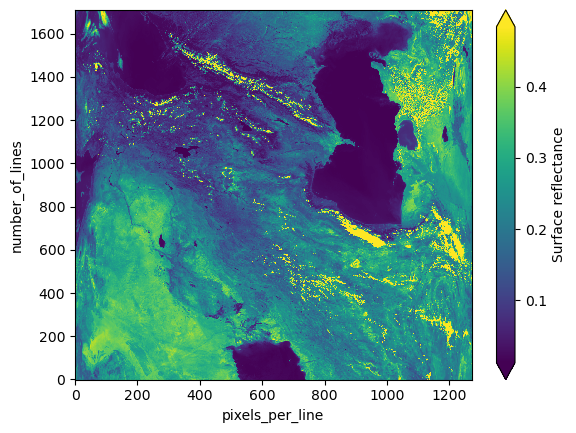

In [14]:
dataset = xr.open_dataset(par["ofile"], group="geophysical_data")
artist = dataset["rhos"].sel({"wavelength_3d": 25}).plot(cmap="viridis", robust=True)

Feel free to explore `l2gen` options to produce the Level-2 dataset you need! The documentation
for `l2gen` is kind of interactive, because so much depends on the data product being processed.
For example, try `l2gen ifile=data/PACE_OCI.20240605T092137.L1B.V2.nc dump_options=true` to get
a lot of information about the specifics of what the `l2gen` program generates.

The next step for this tutorial is to merge multiple Level-2 granules together.

[back to top](#Contents)

## 4. Make MOANA Phytoplankton Community Products with `l2gen`

One of the most exciting new PACE algorithms for the ocean color community is the MOANA algorithm that produces phytoplankton abundances for three different groups: Synechococcus, Prochlorococcus and picoeukaryotes. 

In [15]:
tspan = ("2024-03-09", "2024-03-09")
location = (20, -30)

results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    point=location,
)
results[0]

Collection: {'Version': '2', 'ShortName': 'PACE_OCI_L1B_SCI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -19.32522, 'Longitude': 29.97223}, {'Latitude': -24.58264, 'Longitude': 4.29614}, {'Latitude': -42.41702, 'Longitude': 5.94298}, {'Latitude': -36.6007, 'Longitude': 37.23487}, {'Latitude': -19.32522, 'Longitude': 29.97223}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-03-09T11:59:27Z', 'EndingDateTime': '2024-03-09T12:04:27Z'}}
Size(MB): 1754.9599027633667
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240309T115927.L1B.V2.nc']

Download the granules found in the search.

In [16]:
paths = earthaccess.download(results, local_path="data")

The Level-1B files contain top-of-atmosphere reflectances, typically denoted as $\rho_t$.
On OCI, the reflectances are grouped into blue, red, and short-wave infrared (SWIR) wavelengths. Open
the dataset's "observatin_data" group in the NetCDF file using `xarray` to plot a "rhot_red"
wavelength.

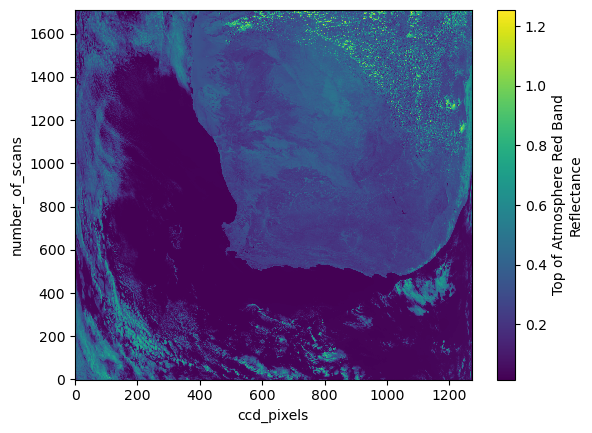

In [17]:
dataset = xr.open_dataset(paths[0], group="observation_data")
artist = dataset["rhot_red"].sel({"red_bands": 100}).plot()

In [18]:
ifile = paths[0]
par = {
    "ifile": ifile,
    "ofile": str(ifile).replace(".L1B.", ".L2_MOANA."),
    "suite": "BGC",
    "l2prod": "picoeuk_moana prococcus_moana syncoccus_moana rhos_465 rhos_555 rhos_645 poc chlor_a ",
    "atmocor": 1,
}
write_par("l2gen-moana.par", par)

Now run `l2bin` using your chosen parameters. Be very patient.

In [19]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen par=l2gen-moana.par

Loading default parameters from /opt/ocssw/share/common/msl12_defaults.par


Input file data/PACE_OCI.20240309T115927.L1B.V2.nc is PACE L1B file.


Loading characteristics for OCI


Opening sensor information file /opt/ocssw/share/oci/msl12_sensor_info.dat


  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw


    0  314.550  112.026 4.873e-01 4.208e-01 3.281e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03


    1  316.239   92.478 6.485e-01 5.806e-01 2.961e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03


    2  318.262   85.195 7.410e-01 5.473e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03


    3  320.303   82.175 7.809e-01 4.609e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03


    4  322.433   80.733 7.906e-01 3.543e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03


    5  324.649   86.251 7.915e-01 2.567e-01 3.018e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03


    6  326.828   95.932 7.891e-01 1.907e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03


    7  328.988  101.672 7.700e-01 1.386e-01 3.251e-19 1.000e+00 0.000e+00 8.211e-02 7.627e-03


    8  331.305  101.708 7.404e-01 9.852e-02 3.417e-19 1.000e+00 0.000e+00 8.089e-02 7.342e-03


    9  333.958   97.745 7.204e-01 6.830e-02 3.572e-19 1.000e+00 0.000e+00 7.656e-02 7.132e-03


   10  336.815   93.497 7.112e-01 4.395e-02 3.736e-19 1.000e+00 0.000e+00 6.891e-02 6.975e-03


   11  339.160   96.099 7.034e-01 3.070e-02 3.963e-19 1.000e+00 0.000e+00 6.288e-02 6.834e-03


   12  341.321   98.332 6.898e-01 2.060e-02 4.076e-19 1.000e+00 0.000e+00 5.915e-02 6.663e-03


   13  343.632   95.167 6.720e-01 1.439e-02 4.137e-19 1.000e+00 0.000e+00 5.624e-02 6.474e-03


   14  346.017   92.958 6.529e-01 9.882e-03 4.395e-19 1.000e+00 0.000e+00 5.365e-02 6.285e-03


   15  348.468   95.422 6.342e-01 6.032e-03 4.610e-19 1.000e+00 0.000e+00 5.106e-02 6.097e-03


   16  350.912   99.423 6.163e-01 4.542e-03 4.617e-19 1.000e+00 0.000e+00 4.864e-02 5.913e-03


   17  353.344  102.927 5.988e-01 3.473e-03 4.768e-19 1.000e+00 0.000e+00 4.647e-02 5.735e-03


   18  355.782   99.180 5.823e-01 2.499e-03 5.019e-19 1.000e+00 0.000e+00 4.450e-02 5.562e-03


   19  358.235   93.459 5.642e-01 2.283e-03 5.089e-19 1.000e+00 0.000e+00 4.256e-02 5.394e-03


   20  360.695   97.255 5.472e-01 2.096e-03 5.117e-19 1.000e+00 0.000e+00 4.053e-02 5.233e-03


   21  363.137  105.330 5.320e-01 1.734e-03 5.326e-19 1.000e+00 0.000e+00 3.856e-02 5.079e-03


   22  365.610  113.914 5.178e-01 1.415e-03 5.533e-19 1.000e+00 0.000e+00 3.642e-02 4.932e-03


   23  368.083  118.845 5.043e-01 1.282e-03 5.555e-19 1.000e+00 0.000e+00 3.417e-02 4.789e-03


   24  370.534  115.549 4.908e-01 1.286e-03 5.590e-19 1.000e+00 0.000e+00 3.126e-02 4.651e-03


   25  372.991  107.218 4.773e-01 1.342e-03 5.744e-19 1.000e+00 0.000e+00 2.719e-02 4.520e-03


   26  375.482  108.880 4.630e-01 1.283e-03 5.834e-19 1.000e+00 0.000e+00 2.270e-02 4.392e-03


   27  377.926  118.137 4.513e-01 1.115e-03 5.861e-19 1.000e+00 0.000e+00 1.843e-02 4.269e-03


   28  380.419  111.060 4.406e-01 1.167e-03 5.945e-19 1.000e+00 0.000e+00 1.508e-02 4.151e-03


   29  382.876   96.370 4.280e-01 1.379e-03 6.014e-19 1.000e+00 0.000e+00 1.316e-02 4.037e-03


   30  385.359   96.688 4.156e-01 1.389e-03 6.039e-19 1.000e+00 0.000e+00 1.228e-02 3.928e-03


   31  387.811  107.161 4.051e-01 1.257e-03 6.130e-19 1.000e+00 0.000e+00 1.166e-02 3.822e-03


   32  390.297  112.501 3.955e-01 1.196e-03 6.227e-19 1.000e+00 0.000e+00 1.104e-02 3.718e-03


   33  392.764  106.686 3.857e-01 1.256e-03 6.193e-19 1.000e+00 0.000e+00 1.065e-02 3.619e-03


   34  395.238  106.058 3.747e-01 1.271e-03 6.157e-19 1.000e+00 0.000e+00 1.040e-02 3.523e-03


   35  397.706  127.304 3.647e-01 1.082e-03 6.328e-19 1.000e+00 0.000e+00 9.891e-03 3.430e-03


   36  400.178  157.144 3.564e-01 9.418e-04 6.342e-19 1.000e+00 0.000e+00 8.906e-03 3.341e-03


   37  402.654  170.763 3.486e-01 9.296e-04 6.155e-19 1.000e+00 0.000e+00 7.976e-03 3.255e-03


   38  405.127  168.889 3.400e-01 9.759e-04 6.015e-19 1.000e+00 0.000e+00 7.534e-03 3.171e-03


   39  407.605  168.988 3.314e-01 1.065e-03 6.101e-19 1.000e+00 0.000e+00 7.203e-03 3.090e-03


   40  410.074  173.399 3.233e-01 1.143e-03 6.226e-19 1.000e+00 0.000e+00 6.868e-03 3.011e-03


   41  412.557  177.268 3.155e-01 1.158e-03 6.161e-19 1.000e+00 0.000e+00 6.656e-03 2.935e-03


   42  415.025  177.759 3.079e-01 1.218e-03 5.856e-19 1.000e+00 0.000e+00 6.564e-03 2.861e-03


   43  417.512  175.925 3.004e-01 1.325e-03 5.698e-19 1.000e+00 0.000e+00 6.661e-03 2.789e-03


   44  419.988  175.156 2.932e-01 1.448e-03 5.927e-19 1.000e+00 0.000e+00 6.771e-03 2.720e-03


   45  422.453  174.012 2.863e-01 1.774e-03 6.054e-19 1.000e+00 0.000e+00 6.878e-03 2.654e-03


   46  424.940  170.766 2.796e-01 2.153e-03 5.793e-19 1.000e+00 0.000e+00 7.006e-03 2.590e-03


   47  427.398  162.027 2.732e-01 2.242e-03 5.468e-19 1.000e+00 0.000e+00 6.986e-03 2.527e-03


   48  429.885  154.088 2.664e-01 2.290e-03 5.331e-19 1.000e+00 0.000e+00 6.994e-03 2.464e-03


   49  432.379  161.564 2.597e-01 2.492e-03 5.452e-19 1.000e+00 0.000e+00 7.152e-03 2.404e-03


   50  434.869  174.172 2.539e-01 2.644e-03 5.549e-19 1.000e+00 0.000e+00 7.438e-03 2.347e-03


   51  437.351  178.115 2.482e-01 3.023e-03 5.355e-19 1.000e+00 0.000e+00 8.014e-03 2.291e-03


   52  439.828  182.229 2.424e-01 3.903e-03 4.968e-19 1.000e+00 0.000e+00 8.606e-03 2.238e-03


   53  442.327  190.795 2.368e-01 4.600e-03 4.726e-19 1.000e+00 0.000e+00 9.139e-03 2.185e-03


   54  444.811  195.628 2.315e-01 4.590e-03 4.945e-19 1.000e+00 0.000e+00 9.759e-03 2.133e-03


   55  447.309  199.848 2.261e-01 4.547e-03 5.107e-19 1.000e+00 0.000e+00 1.052e-02 2.082e-03


   56  449.795  205.764 2.211e-01 4.968e-03 4.798e-19 1.000e+00 0.000e+00 1.131e-02 2.034e-03


   57  452.280  205.708 2.162e-01 5.368e-03 4.441e-19 1.000e+00 0.000e+00 1.179e-02 1.987e-03


   58  454.769  204.450 2.114e-01 5.945e-03 4.252e-19 1.000e+00 0.000e+00 1.203e-02 1.942e-03


   59  457.262  205.953 2.067e-01 7.420e-03 4.263e-19 1.000e+00 0.000e+00 1.212e-02 1.898e-03


   60  459.757  207.117 2.022e-01 9.301e-03 4.351e-19 1.000e+00 0.000e+00 1.214e-02 1.855e-03


   61  462.252  207.870 1.977e-01 1.011e-02 4.326e-19 1.000e+00 0.000e+00 1.219e-02 1.813e-03


   62  464.737  205.886 1.935e-01 9.683e-03 4.061e-19 1.000e+00 0.000e+00 1.238e-02 1.772e-03


   63  467.244  203.675 1.893e-01 9.647e-03 3.691e-19 1.000e+00 0.000e+00 1.242e-02 1.733e-03


   64  469.729  203.713 1.852e-01 1.043e-02 3.441e-19 1.000e+00 0.000e+00 1.244e-02 1.694e-03


   65  472.202  205.281 1.812e-01 1.115e-02 3.582e-19 1.000e+00 0.000e+00 1.276e-02 1.657e-03


   66  474.700  207.058 1.774e-01 1.242e-02 3.801e-19 1.000e+00 0.000e+00 1.326e-02 1.621e-03


   67  477.189  208.385 1.736e-01 1.528e-02 3.580e-19 1.000e+00 0.000e+00 1.393e-02 1.586e-03


   68  479.689  209.553 1.700e-01 1.895e-02 3.338e-19 1.000e+00 0.000e+00 1.437e-02 1.552e-03


   69  482.183  206.590 1.665e-01 2.122e-02 3.022e-19 1.000e+00 0.000e+00 1.472e-02 1.518e-03


   70  484.689  195.340 1.631e-01 2.114e-02 2.725e-19 1.000e+00 0.000e+00 1.533e-02 1.485e-03


   71  487.182  189.524 1.595e-01 2.040e-02 2.939e-19 1.000e+00 0.000e+00 1.612e-02 1.454e-03


   72  489.674  195.470 1.562e-01 2.101e-02 3.044e-19 1.000e+00 0.000e+00 1.694e-02 1.423e-03


   73  492.176  199.211 1.530e-01 2.224e-02 2.853e-19 1.000e+00 0.000e+00 1.789e-02 1.393e-03


   74  494.686  200.274 1.499e-01 2.354e-02 2.822e-19 1.000e+00 0.000e+00 1.916e-02 1.364e-03


   75  497.182  199.355 1.469e-01 2.613e-02 2.498e-19 1.000e+00 0.000e+00 2.072e-02 1.336e-03


   76  499.688  194.720 1.440e-01 3.087e-02 2.022e-19 1.000e+00 0.000e+00 2.233e-02 1.309e-03


   77  502.190  192.753 1.410e-01 3.665e-02 2.151e-19 1.000e+00 0.000e+00 2.438e-02 1.281e-03


   78  504.695  195.557 1.382e-01 4.082e-02 2.384e-19 1.000e+00 0.000e+00 2.700e-02 1.255e-03


   79  507.198  197.605 1.355e-01 4.179e-02 2.315e-19 1.000e+00 0.000e+00 3.003e-02 1.230e-03


   80  509.720  196.520 1.328e-01 4.101e-02 2.296e-19 1.000e+00 0.000e+00 3.389e-02 1.206e-03


   81  512.213  193.098 1.302e-01 4.110e-02 2.157e-19 1.000e+00 0.000e+00 3.784e-02 1.181e-03


   82  514.729  185.769 1.277e-01 4.275e-02 1.772e-19 1.000e+00 0.000e+00 4.045e-02 1.157e-03


   83  517.219  179.326 1.252e-01 4.504e-02 1.597e-19 1.000e+00 0.000e+00 4.179e-02 1.134e-03


   84  519.747  182.521 1.227e-01 4.767e-02 1.620e-19 1.000e+00 0.000e+00 4.270e-02 1.111e-03


   85  522.249  189.089 1.203e-01 5.134e-02 1.624e-19 1.000e+00 0.000e+00 4.337e-02 1.089e-03


   86  524.771  188.823 1.180e-01 5.654e-02 1.755e-19 1.000e+00 0.000e+00 4.387e-02 1.067e-03


   87  527.276  187.920 1.158e-01 6.292e-02 1.771e-19 1.000e+00 0.000e+00 4.454e-02 1.049e-03


   88  529.798  191.821 1.137e-01 6.884e-02 1.592e-19 1.000e+00 0.000e+00 4.553e-02 1.031e-03


   89  532.314  193.286 1.114e-01 7.264e-02 1.423e-19 1.000e+00 0.000e+00 4.646e-02 1.008e-03


   90  534.859  191.915 1.092e-01 7.422e-02 1.168e-19 1.000e+00 0.000e+00 4.742e-02 9.861e-04


   91  537.346  190.229 1.072e-01 7.488e-02 1.024e-19 1.000e+00 0.000e+00 4.852e-02 9.673e-04


   92  539.878  187.754 1.052e-01 7.665e-02 1.097e-19 1.000e+00 0.000e+00 4.966e-02 9.489e-04


   93  542.395  188.298 1.032e-01 7.989e-02 1.240e-19 1.000e+00 0.000e+00 5.116e-02 9.303e-04


   94  544.904  189.892 1.013e-01 8.325e-02 1.296e-19 1.000e+00 0.000e+00 5.328e-02 9.125e-04


   95  547.441  189.629 9.940e-02 8.591e-02 1.237e-19 1.000e+00 0.000e+00 5.584e-02 8.953e-04


   96  549.994  189.342 9.756e-02 8.809e-02 1.129e-19 1.000e+00 0.000e+00 5.851e-02 8.784e-04


   97  552.511  189.725 9.575e-02 9.044e-02 9.907e-20 1.000e+00 0.000e+00 6.062e-02 8.617e-04


   98  555.044  188.862 9.400e-02 9.359e-02 8.268e-20 1.000e+00 0.000e+00 6.191e-02 8.454e-04


   99  557.576  185.867 9.230e-02 9.815e-02 6.751e-20 1.000e+00 0.000e+00 6.298e-02 8.297e-04


  100  560.104  184.284 9.062e-02 1.041e-01 6.704e-20 1.000e+00 0.000e+00 6.443e-02 8.146e-04


  101  562.642  184.903 8.899e-02 1.101e-01 8.271e-20 1.000e+00 0.000e+00 6.592e-02 7.997e-04


  102  565.190  184.929 8.737e-02 1.152e-01 8.817e-20 1.000e+00 0.000e+00 6.740e-02 7.846e-04


  103  567.710  184.394 8.579e-02 1.194e-01 8.097e-20 1.000e+00 0.000e+00 6.954e-02 7.698e-04


  104  570.259  184.337 8.424e-02 1.231e-01 8.258e-20 1.000e+00 0.000e+00 7.243e-02 7.555e-04


  105  572.796  185.701 8.273e-02 1.258e-01 7.445e-20 1.000e+00 0.000e+00 7.601e-02 7.418e-04


  106  575.343  185.860 8.130e-02 1.262e-01 5.358e-20 1.000e+00 0.000e+00 8.077e-02 7.290e-04


  107  577.902  184.295 7.992e-02 1.245e-01 4.606e-20 1.000e+00 0.000e+00 8.675e-02 7.169e-04


  108  580.450  184.370 7.850e-02 1.217e-01 4.637e-20 1.000e+00 0.000e+00 9.411e-02 7.037e-04


  109  582.996  184.516 7.711e-02 1.191e-01 4.563e-20 1.000e+00 0.000e+00 1.036e-01 6.904e-04


  110  585.553  182.261 7.581e-02 1.175e-01 4.880e-20 1.000e+00 0.000e+00 1.147e-01 6.784e-04


  111  588.086  178.467 7.455e-02 1.172e-01 5.159e-20 1.000e+00 0.000e+00 1.271e-01 6.670e-04


  112  590.548  177.770 7.336e-02 1.186e-01 5.765e-20 1.000e+00 0.000e+00 1.411e-01 6.570e-04


  113  593.084  179.810 7.228e-02 1.222e-01 5.611e-20 1.000e+00 0.000e+00 1.572e-01 6.487e-04


  114  595.679  179.992 7.117e-02 1.275e-01 4.249e-20 1.000e+00 0.000e+00 1.772e-01 6.390e-04


  115  598.262  178.361 6.999e-02 1.328e-01 3.893e-20 1.000e+00 0.000e+00 2.030e-01 6.276e-04


  116  600.545  176.370 6.757e-02 1.365e-01 3.874e-20 1.000e+00 0.000e+00 2.467e-01 5.992e-04


  117  602.920  176.174 6.651e-02 1.374e-01 3.034e-20 1.000e+00 0.000e+00 2.611e-01 5.899e-04


  118  605.461  176.473 6.543e-02 1.353e-01 2.076e-20 1.000e+00 0.000e+00 2.702e-01 5.801e-04


  119  607.986  174.705 6.437e-02 1.310e-01 1.990e-20 1.000e+00 0.000e+00 2.728e-01 5.706e-04


  120  610.360  172.381 6.335e-02 1.256e-01 2.700e-20 1.000e+00 0.000e+00 2.733e-01 5.614e-04


  121  612.730  170.269 6.236e-02 1.202e-01 3.487e-20 1.000e+00 0.000e+00 2.746e-01 5.524e-04


  122  615.145  167.881 6.137e-02 1.152e-01 3.541e-20 1.000e+00 0.000e+00 2.763e-01 5.434e-04


  123  617.605  167.707 6.038e-02 1.107e-01 3.180e-20 1.000e+00 0.000e+00 2.790e-01 5.346e-04


  124  620.061  168.940 5.942e-02 1.070e-01 2.798e-20 1.000e+00 0.000e+00 2.832e-01 5.259e-04


  125  622.530  167.529 5.848e-02 1.038e-01 2.439e-20 1.000e+00 0.000e+00 2.876e-01 5.173e-04


  126  624.988  165.875 5.754e-02 1.007e-01 2.069e-20 1.000e+00 0.000e+00 2.918e-01 5.089e-04


  127  627.434  166.459 5.663e-02 9.740e-02 1.634e-20 1.000e+00 0.000e+00 2.963e-01 5.006e-04


  128  629.898  165.893 5.575e-02 9.400e-02 1.319e-20 1.000e+00 0.000e+00 3.008e-01 4.925e-04


  129  632.376  164.212 5.486e-02 9.046e-02 1.304e-20 1.000e+00 0.000e+00 3.055e-01 4.846e-04


  130  634.830  163.727 5.400e-02 8.676e-02 1.402e-20 1.000e+00 0.000e+00 3.097e-01 4.768e-04


  131  637.305  163.541 5.316e-02 8.287e-02 1.464e-20 1.000e+00 0.000e+00 3.137e-01 4.692e-04


  132  639.791  162.086 5.234e-02 7.890e-02 1.583e-20 1.000e+00 0.000e+00 3.191e-01 4.618e-04


  133  641.029  161.259 5.193e-02 7.696e-02 1.681e-20 1.000e+00 0.000e+00 3.224e-01 4.581e-04


  134  642.255  160.668 5.152e-02 7.512e-02 1.767e-20 1.000e+00 0.000e+00 3.258e-01 4.545e-04


  135  643.479  160.372 5.112e-02 7.339e-02 1.849e-20 1.000e+00 0.000e+00 3.293e-01 4.509e-04


  136  644.716  160.231 5.073e-02 7.176e-02 1.919e-20 1.000e+00 0.000e+00 3.327e-01 4.473e-04


  137  645.966  159.889 5.034e-02 7.021e-02 1.946e-20 1.000e+00 0.000e+00 3.360e-01 4.437e-04


  138  647.188  159.260 4.995e-02 6.871e-02 1.898e-20 1.000e+00 0.000e+00 3.396e-01 4.402e-04


  139  648.435  158.731 4.956e-02 6.727e-02 1.756e-20 1.000e+00 0.000e+00 3.436e-01 4.367e-04


  140  649.667  158.341 4.918e-02 6.588e-02 1.544e-20 1.000e+00 0.000e+00 3.486e-01 4.333e-04


  141  650.913  158.275 4.880e-02 6.453e-02 1.328e-20 1.000e+00 0.000e+00 3.546e-01 4.299e-04


  142  652.153  157.789 4.843e-02 6.321e-02 1.167e-20 1.000e+00 0.000e+00 3.616e-01 4.265e-04


  143  653.388  155.177 4.807e-02 6.193e-02 1.068e-20 1.000e+00 0.000e+00 3.693e-01 4.231e-04


  144  654.622  151.698 4.771e-02 6.060e-02 9.722e-21 1.000e+00 0.000e+00 3.774e-01 4.198e-04


  145  655.869  148.463 4.733e-02 5.922e-02 8.805e-21 1.000e+00 0.000e+00 3.858e-01 4.166e-04


  146  657.101  147.695 4.695e-02 5.782e-02 7.987e-21 1.000e+00 0.000e+00 3.947e-01 4.133e-04


  147  658.340  149.658 4.658e-02 5.648e-02 7.170e-21 1.000e+00 0.000e+00 4.036e-01 4.101e-04


  148  659.600  152.493 4.623e-02 5.523e-02 6.329e-21 1.000e+00 0.000e+00 4.119e-01 4.070e-04


  149  660.833  154.868 4.590e-02 5.404e-02 5.541e-21 1.000e+00 0.000e+00 4.192e-01 4.038e-04


  150  662.067  155.409 4.555e-02 5.283e-02 4.976e-21 1.000e+00 0.000e+00 4.251e-01 4.007e-04


  151  663.300  155.290 4.521e-02 5.158e-02 4.897e-21 1.000e+00 0.000e+00 4.297e-01 3.976e-04


  152  664.564  155.005 4.487e-02 5.029e-02 5.478e-21 1.000e+00 0.000e+00 4.334e-01 3.945e-04


  153  665.795  154.711 4.453e-02 4.895e-02 6.640e-21 1.000e+00 0.000e+00 4.363e-01 3.915e-04


  154  667.023  154.401 4.420e-02 4.759e-02 7.980e-21 1.000e+00 0.000e+00 4.389e-01 3.885e-04


  155  668.263  154.028 4.387e-02 4.622e-02 9.022e-21 1.000e+00 0.000e+00 4.415e-01 3.855e-04


  156  669.518  153.439 4.354e-02 4.488e-02 9.638e-21 1.000e+00 0.000e+00 4.442e-01 3.825e-04


  157  670.755  152.834 4.321e-02 4.356e-02 9.943e-21 1.000e+00 0.000e+00 4.471e-01 3.796e-04


  158  671.990  152.273 4.289e-02 4.229e-02 1.010e-20 1.000e+00 0.000e+00 4.497e-01 3.767e-04


  159  673.245  151.870 4.257e-02 4.107e-02 1.027e-20 1.000e+00 0.000e+00 4.523e-01 3.738e-04


  160  674.503  151.619 4.225e-02 3.991e-02 1.027e-20 1.000e+00 0.000e+00 4.551e-01 3.710e-04


  161  675.731  151.421 4.194e-02 3.879e-02 9.926e-21 1.000e+00 0.000e+00 4.583e-01 3.681e-04


  162  676.963  151.155 4.163e-02 3.774e-02 9.232e-21 1.000e+00 0.000e+00 4.620e-01 3.654e-04


  163  678.208  150.791 4.132e-02 3.675e-02 8.304e-21 1.000e+00 0.000e+00 4.661e-01 3.626e-04


  164  679.448  150.430 4.102e-02 3.584e-02 7.379e-21 1.000e+00 0.000e+00 4.703e-01 3.599e-04


  165  680.680  149.905 4.072e-02 3.503e-02 6.552e-21 1.000e+00 0.000e+00 4.747e-01 3.572e-04


  166  681.919  149.251 4.042e-02 3.430e-02 5.895e-21 1.000e+00 0.000e+00 4.794e-01 3.545e-04


  167  683.171  148.503 4.012e-02 3.361e-02 5.490e-21 1.000e+00 0.000e+00 4.845e-01 3.518e-04


  168  684.417  147.884 3.983e-02 3.292e-02 5.184e-21 1.000e+00 0.000e+00 4.901e-01 3.492e-04


  169  685.657  147.515 3.953e-02 3.216e-02 4.905e-21 1.000e+00 0.000e+00 4.962e-01 3.466e-04


  170  686.894  147.425 3.924e-02 3.131e-02 4.525e-21 1.000e+00 0.000e+00 5.029e-01 3.440e-04


  171  688.143  147.400 3.896e-02 3.039e-02 4.024e-21 1.000e+00 0.000e+00 5.103e-01 3.414e-04


  172  689.394  147.153 3.867e-02 2.943e-02 3.539e-21 1.000e+00 0.000e+00 5.186e-01 3.389e-04


  173  690.647  146.715 3.839e-02 2.845e-02 3.144e-21 1.000e+00 0.000e+00 5.276e-01 3.363e-04


  174  691.888  146.143 3.811e-02 2.750e-02 2.906e-21 1.000e+00 0.000e+00 5.375e-01 3.338e-04


  175  693.130  145.684 3.784e-02 2.657e-02 2.763e-21 1.000e+00 0.000e+00 5.484e-01 3.314e-04


  176  694.382  145.196 3.756e-02 2.567e-02 2.656e-21 1.000e+00 0.000e+00 5.605e-01 3.289e-04


  177  695.644  144.701 3.729e-02 2.479e-02 2.542e-21 1.000e+00 0.000e+00 5.740e-01 3.265e-04


  178  696.891  144.099 3.702e-02 2.394e-02 2.429e-21 1.000e+00 0.000e+00 5.888e-01 3.241e-04


  179  698.118  143.280 3.676e-02 2.315e-02 2.343e-21 1.000e+00 0.000e+00 6.047e-01 3.217e-04


  180  699.376  142.397 3.649e-02 2.241e-02 2.369e-21 1.000e+00 0.000e+00 6.215e-01 3.193e-04


  181  700.612  141.532 3.623e-02 2.174e-02 2.581e-21 1.000e+00 0.000e+00 6.393e-01 3.170e-04


  182  701.858  141.039 3.597e-02 2.114e-02 3.030e-21 1.000e+00 0.000e+00 6.580e-01 3.147e-04


  183  703.097  140.869 3.571e-02 2.061e-02 3.660e-21 1.000e+00 0.000e+00 6.780e-01 3.124e-04


  184  704.354  140.969 3.546e-02 2.014e-02 4.374e-21 1.000e+00 0.000e+00 6.995e-01 3.101e-04


  185  705.593  140.996 3.521e-02 1.972e-02 4.920e-21 1.000e+00 0.000e+00 7.231e-01 3.078e-04


  186  706.833  140.760 3.496e-02 1.934e-02 5.156e-21 1.000e+00 0.000e+00 7.499e-01 3.056e-04


  187  708.089  140.307 3.471e-02 1.900e-02 5.111e-21 1.000e+00 0.000e+00 7.805e-01 3.034e-04


  188  709.337  139.705 3.446e-02 1.868e-02 4.920e-21 1.000e+00 0.000e+00 8.152e-01 3.012e-04


  189  710.581  139.142 3.422e-02 1.842e-02 4.776e-21 1.000e+00 0.000e+00 8.540e-01 2.990e-04


  190  711.826  138.503 3.398e-02 1.820e-02 4.601e-21 1.000e+00 0.000e+00 8.959e-01 2.968e-04


  191  713.068  137.918 3.374e-02 1.804e-02 4.294e-21 1.000e+00 0.000e+00 9.408e-01 2.947e-04


  192  714.316  137.373 3.350e-02 1.788e-02 3.751e-21 1.000e+00 0.000e+00 9.886e-01 2.926e-04


  193  716.817  136.139 3.303e-02 1.733e-02 2.447e-21 1.000e+00 0.000e+00 1.093e+00 2.884e-04


  194  719.298  134.747 3.257e-02 1.625e-02 1.823e-21 1.000e+00 0.000e+00 1.206e+00 2.843e-04


  195  721.800  134.248 3.212e-02 1.496e-02 1.858e-21 1.000e+00 0.000e+00 1.327e+00 2.802e-04


  196  724.303  134.303 3.167e-02 1.391e-02 1.678e-21 1.000e+00 0.000e+00 1.461e+00 2.763e-04


  197  726.796  133.424 3.124e-02 1.304e-02 1.167e-21 1.000e+00 0.000e+00 1.642e+00 2.724e-04


  198  729.299  132.173 3.081e-02 1.220e-02 8.984e-22 1.000e+00 0.000e+00 1.891e+00 2.686e-04


  199  731.790  131.770 3.038e-02 1.153e-02 9.392e-22 1.000e+00 0.000e+00 2.176e+00 2.648e-04


  200  734.281  131.420 2.997e-02 1.114e-02 1.157e-21 1.000e+00 0.000e+00 2.438e+00 2.611e-04


  201  736.791  130.150 2.956e-02 1.096e-02 1.301e-21 1.000e+00 0.000e+00 2.621e+00 2.575e-04


  202  739.287  128.259 2.916e-02 1.090e-02 1.303e-21 1.000e+00 0.000e+00 2.732e+00 2.539e-04


  203  740.535  127.659 2.897e-02 1.094e-02 1.339e-21 1.000e+00 0.000e+00 2.770e+00 2.521e-04


  204  741.785  127.339 2.877e-02 1.103e-02 1.496e-21 1.000e+00 0.000e+00 2.799e+00 2.504e-04


  205  743.046  127.458 2.857e-02 1.119e-02 1.813e-21 1.000e+00 0.000e+00 2.819e+00 2.486e-04


  206  744.286  127.660 2.838e-02 1.137e-02 2.155e-21 1.000e+00 0.000e+00 2.832e+00 2.469e-04


  207  745.534  127.796 2.819e-02 1.153e-02 2.323e-21 1.000e+00 0.000e+00 2.840e+00 2.452e-04


  208  746.789  127.697 2.800e-02 1.159e-02 2.205e-21 1.000e+00 0.000e+00 2.846e+00 2.435e-04


  209  748.041  127.310 2.781e-02 1.150e-02 1.876e-21 1.000e+00 0.000e+00 2.850e+00 2.419e-04


  210  749.279  126.838 2.762e-02 1.122e-02 1.554e-21 1.000e+00 0.000e+00 2.854e+00 2.402e-04


  211  750.540  126.351 2.744e-02 1.074e-02 1.390e-21 1.000e+00 0.000e+00 2.857e+00 2.386e-04


  212  751.792  126.028 2.725e-02 1.013e-02 1.397e-21 1.000e+00 0.000e+00 2.862e+00 2.369e-04


  213  753.042  125.814 2.707e-02 9.483e-03 1.443e-21 1.000e+00 0.000e+00 2.867e+00 2.353e-04


  214  754.294  125.571 2.689e-02 8.866e-03 1.420e-21 1.000e+00 0.000e+00 2.870e+00 2.337e-04


  215  755.542  125.152 2.671e-02 8.328e-03 1.307e-21 1.000e+00 0.000e+00 2.872e+00 2.321e-04


  216  756.802  124.719 2.654e-02 7.888e-03 1.121e-21 1.000e+00 0.000e+00 2.871e+00 2.305e-04


  217  758.051  124.328 2.636e-02 7.536e-03 8.963e-22 1.000e+00 0.000e+00 2.869e+00 2.290e-04


  218  759.299  124.043 2.618e-02 7.263e-03 6.951e-22 1.000e+00 0.000e+00 2.868e+00 2.274e-04


  219  760.558  123.914 2.601e-02 7.046e-03 5.663e-22 1.000e+00 0.000e+00 2.867e+00 2.259e-04


  220  761.802  123.750 2.584e-02 6.870e-03 5.311e-22 1.000e+00 0.000e+00 2.866e+00 2.243e-04


  221  763.060  123.256 2.567e-02 6.729e-03 5.615e-22 1.000e+00 0.000e+00 2.864e+00 2.228e-04


  222  764.310  122.509 2.550e-02 6.613e-03 6.061e-22 1.000e+00 0.000e+00 2.859e+00 2.213e-04


  223  765.557  121.681 2.534e-02 6.524e-03 6.186e-22 1.000e+00 0.000e+00 2.851e+00 2.198e-04


  224  766.815  121.062 2.517e-02 6.466e-03 5.746e-22 1.000e+00 0.000e+00 2.843e+00 2.184e-04


  225  768.071  120.731 2.500e-02 6.448e-03 4.879e-22 1.000e+00 0.000e+00 2.834e+00 2.169e-04


  226  769.326  120.550 2.484e-02 6.482e-03 3.904e-22 1.000e+00 0.000e+00 2.824e+00 2.155e-04


  227  770.564  120.456 2.468e-02 6.585e-03 3.155e-22 1.000e+00 0.000e+00 2.813e+00 2.140e-04


  228  771.823  120.093 2.452e-02 6.768e-03 2.764e-22 1.000e+00 0.000e+00 2.800e+00 2.126e-04


  229  773.074  119.833 2.436e-02 7.035e-03 2.723e-22 1.000e+00 0.000e+00 2.786e+00 2.112e-04


  230  774.338  119.604 2.420e-02 7.369e-03 2.949e-22 1.000e+00 0.000e+00 2.771e+00 2.098e-04


  231  776.832  119.136 2.389e-02 8.069e-03 3.684e-22 1.000e+00 0.000e+00 2.741e+00 2.070e-04


  232  779.336  118.623 2.358e-02 8.375e-03 4.135e-22 1.000e+00 0.000e+00 2.699e+00 2.043e-04


  233  781.843  118.090 2.328e-02 7.962e-03 4.360e-22 1.000e+00 0.000e+00 2.650e+00 2.016e-04


  234  784.350  117.590 2.298e-02 7.054e-03 4.865e-22 1.000e+00 0.000e+00 2.598e+00 1.990e-04


  235  786.855  117.193 2.269e-02 6.138e-03 6.189e-22 1.000e+00 0.000e+00 2.541e+00 1.964e-04


  236  789.367  116.427 2.240e-02 5.442e-03 8.418e-22 1.000e+00 0.000e+00 2.482e+00 1.939e-04


  237  791.865  114.579 2.212e-02 4.901e-03 7.865e-22 1.000e+00 0.000e+00 2.423e+00 1.914e-04


  238  794.382  113.306 2.184e-02 4.449e-03 4.479e-22 1.000e+00 0.000e+00 2.369e+00 1.889e-04


  239  796.881  113.682 2.157e-02 4.130e-03 2.896e-22 1.000e+00 0.000e+00 2.321e+00 1.865e-04


  240  799.394  113.560 2.130e-02 3.943e-03 3.150e-22 1.000e+00 0.000e+00 2.274e+00 1.841e-04


  241  801.901  112.589 2.104e-02 3.847e-03 3.325e-22 1.000e+00 0.000e+00 2.236e+00 1.818e-04


  242  804.409  111.657 2.078e-02 3.891e-03 2.312e-22 1.000e+00 0.000e+00 2.212e+00 1.794e-04


  243  806.913  110.856 2.052e-02 4.171e-03 1.138e-22 1.000e+00 0.000e+00 2.196e+00 1.772e-04


  244  809.428  110.319 2.027e-02 4.692e-03 9.675e-23 1.000e+00 0.000e+00 2.192e+00 1.750e-04


  245  811.932  110.212 2.003e-02 5.313e-03 1.269e-22 1.000e+00 0.000e+00 2.203e+00 1.728e-04


  246  814.440  109.950 1.979e-02 5.836e-03 1.403e-22 1.000e+00 0.000e+00 2.232e+00 1.706e-04


  247  816.943  108.713 1.955e-02 6.024e-03 1.070e-22 1.000e+00 0.000e+00 2.276e+00 1.685e-04


  248  819.456  107.005 1.932e-02 5.699e-03 6.941e-23 1.000e+00 0.000e+00 2.340e+00 1.665e-04


  249  821.961  106.334 1.908e-02 4.916e-03 6.586e-23 1.000e+00 0.000e+00 2.440e+00 1.644e-04


  250  824.462  106.615 1.885e-02 3.982e-03 8.298e-23 1.000e+00 0.000e+00 2.605e+00 1.623e-04


  251  826.984  106.526 1.862e-02 3.185e-03 1.014e-22 1.000e+00 0.000e+00 2.847e+00 1.603e-04


  252  829.489  105.761 1.840e-02 2.620e-03 1.147e-22 1.000e+00 0.000e+00 3.138e+00 1.583e-04


  253  832.005  104.362 1.817e-02 2.259e-03 1.471e-22 1.000e+00 0.000e+00 3.434e+00 1.564e-04


  254  834.507  103.505 1.795e-02 2.051e-03 1.970e-22 1.000e+00 0.000e+00 3.664e+00 1.544e-04


  255  837.018  103.416 1.774e-02 1.974e-03 1.945e-22 1.000e+00 0.000e+00 3.810e+00 1.526e-04


  256  839.516  103.189 1.754e-02 1.990e-03 1.761e-22 1.000e+00 0.000e+00 3.914e+00 1.508e-04


  257  842.031  102.548 1.733e-02 2.081e-03 1.913e-22 1.000e+00 0.000e+00 3.996e+00 1.489e-04


  258  844.538  101.894 1.713e-02 2.267e-03 1.738e-22 1.000e+00 0.000e+00 4.064e+00 1.471e-04


  259  847.062  100.764 1.693e-02 2.602e-03 1.158e-22 1.000e+00 0.000e+00 4.128e+00 1.453e-04


  260  849.572   98.537 1.673e-02 3.172e-03 7.480e-23 1.000e+00 0.000e+00 4.189e+00 1.436e-04


  261  852.086   94.626 1.654e-02 3.781e-03 8.119e-23 1.000e+00 0.000e+00 4.243e+00 1.419e-04


  262  854.586   92.389 1.634e-02 3.974e-03 1.025e-22 1.000e+00 0.000e+00 4.301e+00 1.402e-04


  263  857.103   95.844 1.614e-02 3.669e-03 8.662e-23 1.000e+00 0.000e+00 4.366e+00 1.385e-04


  264  859.594   98.543 1.595e-02 3.165e-03 6.504e-23 1.000e+00 0.000e+00 4.432e+00 1.368e-04


  265  862.112   97.885 1.577e-02 2.572e-03 6.390e-23 1.000e+00 0.000e+00 4.501e+00 1.352e-04


  266  864.610   94.383 1.560e-02 2.051e-03 5.998e-23 1.000e+00 0.000e+00 4.585e+00 1.336e-04


  267  867.113   92.034 1.542e-02 1.649e-03 6.107e-23 1.000e+00 0.000e+00 4.670e+00 1.321e-04


  268  869.613   94.195 1.524e-02 1.362e-03 6.062e-23 1.000e+00 0.000e+00 4.755e+00 1.305e-04


  269  872.129   95.128 1.507e-02 1.178e-03 5.796e-23 1.000e+00 0.000e+00 4.860e+00 1.290e-04


  270  874.636   94.383 1.490e-02 1.081e-03 6.097e-23 1.000e+00 0.000e+00 4.980e+00 1.275e-04


  271  877.145   94.042 1.472e-02 1.057e-03 6.736e-23 1.000e+00 0.000e+00 5.110e+00 1.260e-04


  272  879.637   93.568 1.456e-02 1.097e-03 7.289e-23 1.000e+00 0.000e+00 5.252e+00 1.245e-04


  273  882.136   93.350 1.440e-02 1.184e-03 7.406e-23 1.000e+00 0.000e+00 5.399e+00 1.231e-04


  274  884.639   93.096 1.424e-02 1.303e-03 7.027e-23 1.000e+00 0.000e+00 5.535e+00 1.217e-04


  275  887.130   92.483 1.408e-02 1.422e-03 7.840e-23 1.000e+00 0.000e+00 5.669e+00 1.203e-04


  276  889.598   92.305 1.393e-02 1.469e-03 1.132e-22 1.000e+00 0.000e+00 5.813e+00 1.190e-04


  277  892.093   91.818 1.378e-02 1.484e-03 1.219e-22 1.000e+00 0.000e+00 5.950e+00 1.177e-04


  278  894.601   91.425 1.364e-02 1.610e-03 9.420e-23 1.000e+00 0.000e+00 6.078e+00 1.164e-04


  279  939.713   81.998 1.109e-02 5.011e-04 7.228e-24 1.000e+00 0.000e+00 2.247e+01 9.450e-05


  280 1038.317   66.984 7.465e-03 3.476e-05 3.122e-27 1.000e+00 0.000e+00 2.308e+01 6.293e-05


  281 1248.550   44.519 3.536e-03 8.538e-09 1.212e-26 1.000e+00 0.000e+00 1.125e+02 2.952e-05


  282 1378.169   35.562 2.376e-03 1.117e-08 3.016e-26 1.000e+00 0.000e+00 5.588e+02 1.971e-05


  283 1618.034   23.487 1.252e-03 3.024e-09 8.983e-27 1.000e+00 0.000e+00 7.136e+02 1.026e-05


  284 2130.593    9.111 4.152e-04 1.149e-08 3.418e-26 1.000e+00 0.000e+00 2.521e+03 3.356e-06


  285 2258.429    7.397 3.292e-04 9.446e-09 2.821e-26 1.000e+00 0.000e+00 2.208e+03 2.651e-06


Loading default parameters for OCI from /opt/ocssw/share/oci/msl12_defaults.par


Loading parameters for suite BGC from /opt/ocssw/share/oci/msl12_defaults_BGC.par


Loading command line parameters


Loading user parameters for OCI


Internal data compression requested at compression level: 4


Opening filter file /opt/ocssw/share/oci/msl12_filter.dat


Setting 5 x 3 straylight filter on CLDICE mask


Filter Kernel


1 1 1 1 1 


1 1 1 1 1 


1 1 1 1 1 


Minimum fill set to 1 pixels


Opening OCI L1B file


OCI L1B Npix  :1272 Nlines:1710


file->nbands = 286


Allocated 32313760 bytes in L1 record.


Allocated 14633960 bytes in error record.


Allocated 16067904 bytes in L2 record.


Opening: data/PACE_OCI.20240309T115927.L2_MOANA.V2.nc


The following products will be included in data/PACE_OCI.20240309T115927.L2_MOANA.V2.nc.


0 picoeuk_moana


1 prococcus_moana


2 syncoccus_moana


3 rhos_465


4 rhos_555


5 rhos_645


6 poc


7 chlor_a


8 l2_flags


Begin l2gen Version 9.7.0-V2024.1 Processing


Sensor is OCI


Sensor ID is 30


Sensor has 286 reflective bands


Sensor has 0 emissive bands


Number of along-track detectors per band is 1


Number of input pixels per scan is 1272


Processing pixels 1 to 1272 by 1


Processing scans 1 to 1710 by 1


Ocean processing enabled


Land processing enabled


Atmospheric correction enabled


Begin MSl12 processing at 2024217030520000


Allocated 32313760 bytes in L1 record.


Allocated 32313760 bytes in L1 record.


Allocated 32313760 bytes in L1 record.


Allocated 14633960 bytes in error record.


Allocated 14633960 bytes in error record.


Allocated 14633960 bytes in error record.


Loading land mask information from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading DEM information from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading ice mask file from /opt/ocssw/share/common/ice_climatology.hdf


Loaded monthly NSIDC ice climatology HDF file.


Loading DEM info from /opt/ocssw/share/common/gebco_ocssw_v2020.nc


Loading climatology file /opt/ocssw/share/common/sst_climatology.hdf


Loading SSS reference from Climatology file: /opt/ocssw/share/common/sss_climatology_woa2009.hdf


Opening meteorological files.


  met1   = /opt/ocssw/share/common/met_climatology_v2014.hdf


  met2   = 


  met3   = 


  ozone1 = /opt/ocssw/share/common/ozone_climatology_v2014.hdf


  ozone2 = 


  ozone3 = 


  no2    = /opt/ocssw/share/common/no2_climatology_v2013.hdf


Opening ozone file /opt/ocssw/share/common/ozone_climatology_v2014.hdf


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_315_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_316_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_318_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_320_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_322_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_325_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_327_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_329_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_331_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_334_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_337_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_339_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_341_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_344_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_346_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_348_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_351_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_353_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_356_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_358_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_361_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_363_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_366_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_368_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_371_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_373_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_375_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_378_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_380_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_383_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_385_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_388_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_390_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_393_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_395_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_398_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_400_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_403_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_405_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_408_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_410_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_413_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_415_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_418_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_420_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_422_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_425_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_427_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_430_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_432_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_435_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_437_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_440_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_442_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_445_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_447_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_450_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_452_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_455_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_457_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_460_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_462_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_465_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_467_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_470_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_472_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_475_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_477_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_480_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_482_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_485_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_487_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_490_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_492_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_495_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_497_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_500_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_502_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_505_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_507_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_510_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_512_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_515_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_517_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_520_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_522_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_525_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_527_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_530_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_532_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_535_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_537_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_540_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_542_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_545_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_547_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_550_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_553_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_555_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_558_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_560_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_563_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_565_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_568_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_570_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_573_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_575_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_578_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_580_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_583_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_586_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_588_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_591_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_593_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_596_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_598_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_601_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_603_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_605_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_608_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_610_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_613_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_615_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_618_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_620_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_623_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_625_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_627_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_630_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_632_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_635_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_637_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_640_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_641_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_642_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_643_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_645_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_646_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_647_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_648_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_650_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_651_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_652_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_653_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_655_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_656_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_657_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_658_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_660_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_661_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_662_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_663_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_665_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_666_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_667_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_668_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_670_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_671_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_672_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_673_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_675_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_676_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_677_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_678_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_679_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_681_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_682_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_683_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_684_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_686_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_687_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_688_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_689_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_691_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_692_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_693_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_694_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_696_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_697_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_698_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_699_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_701_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_702_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_703_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_704_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_706_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_707_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_708_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_709_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_711_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_712_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_713_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_714_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_717_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_719_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_722_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_724_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_727_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_729_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_732_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_734_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_737_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_739_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_741_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_742_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_743_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_744_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_746_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_747_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_748_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_749_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_751_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_752_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_753_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_754_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_756_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_757_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_758_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_759_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_761_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_762_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_763_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_764_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_766_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_767_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_768_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_769_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_771_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_772_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_773_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_774_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_777_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_779_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_782_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_784_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_787_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_789_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_792_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_794_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_797_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_799_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_802_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_804_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_807_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_809_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_812_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_814_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_817_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_819_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_822_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_824_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_827_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_829_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_832_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_835_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_837_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_840_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_842_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_845_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_847_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_850_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_852_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_855_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_857_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_860_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_862_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_865_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_867_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_870_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_872_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_875_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_877_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_880_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_882_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_885_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_887_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_890_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_892_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_895_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_940_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1038_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1249_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1378_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_1618_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_2131_iqu.nc


Loading Rayleigh LUT /opt/ocssw/share/oci/rayleigh/rayleigh_oci_2258_iqu.nc


Using  869.6 nm channel for cloud flagging over water.


Using  412.6 nm channel for cloud flagging over land.


Reading uncertainty from: /opt/ocssw/share/oci/uncertainty.nc


Processing scan #     0 (1 of 1710) after      9 seconds


Aerosol selection bands 751 and 870


NIR correction enabled --> for spectral matching.


Loading aerosol models from /opt/ocssw/share/oci/aerosol/aerosol_oci


Number of Wavelengths                          286


Number of Solar Zenith Angles                  45


Number of View Zenith Angles                   41


Number of Relative Azimuth Angles              20


Number of Principal Components                 30


Number of tau 870 Angles                       9


Limiting aerosol models based on RH.


Using Spectral Matching of aerosols reflectance for


wavelength from 750.5 nm to 869.6 nm for model selection


Allocated 14633960 bytes in error record.


Allocated 14633960 bytes in error record.


80 aerosol models: 8 humidities x 10 size fractions


model 0, rh=30.000002, sd=5, alpha=2.195868, name=r30f95


model 1, rh=30.000002, sd=20, alpha=2.080902, name=r30f80


model 2, rh=30.000002, sd=50, alpha=1.741297, name=r30f50


model 3, rh=30.000002, sd=70, alpha=1.353765, name=r30f30


model 4, rh=30.000002, sd=80, alpha=1.055717, name=r30f20


model 5, rh=30.000002, sd=90, alpha=0.613691, name=r30f10


model 6, rh=30.000002, sd=95, alpha=0.291905, name=r30f05


model 7, rh=30.000002, sd=98, alpha=0.041746, name=r30f02


model 8, rh=30.000002, sd=99, alpha=-0.055294, name=r30f01


model 9, rh=30.000002, sd=100, alpha=-0.160986, name=r30f00


model 10, rh=50.000000, sd=5, alpha=2.185652, name=r50f95


model 11, rh=50.000000, sd=20, alpha=2.072113, name=r50f80


model 12, rh=50.000000, sd=50, alpha=1.736037, name=r50f50


model 13, rh=50.000000, sd=70, alpha=1.351452, name=r50f30


model 14, rh=50.000000, sd=80, alpha=1.055006, name=r50f20


model 15, rh=50.000000, sd=90, alpha=0.614437, name=r50f10


model 16, rh=50.000000, sd=95, alpha=0.293084, name=r50f05


model 17, rh=50.000000, sd=98, alpha=0.042913, name=r50f02


model 18, rh=50.000000, sd=99, alpha=-0.054214, name=r50f01


model 19, rh=50.000000, sd=100, alpha=-0.160053, name=r50f00


model 20, rh=70.000000, sd=5, alpha=2.162975, name=r70f95


model 21, rh=70.000000, sd=20, alpha=2.066226, name=r70f80


model 22, rh=70.000000, sd=50, alpha=1.770589, name=r70f50


model 23, rh=70.000000, sd=70, alpha=1.416016, name=r70f30


model 24, rh=70.000000, sd=80, alpha=1.131202, name=r70f20


model 25, rh=70.000000, sd=90, alpha=0.689151, name=r70f10


model 26, rh=70.000000, sd=95, alpha=0.351549, name=r70f05


model 27, rh=70.000000, sd=98, alpha=0.078747, name=r70f02


model 28, rh=70.000000, sd=99, alpha=-0.029792, name=r70f01


model 29, rh=70.000000, sd=100, alpha=-0.149895, name=r70f00


model 30, rh=75.000000, sd=5, alpha=2.118432, name=r75f95


model 31, rh=75.000000, sd=20, alpha=2.038649, name=r75f80


model 32, rh=75.000000, sd=50, alpha=1.786870, name=r75f50


model 33, rh=75.000000, sd=70, alpha=1.469576, name=r75f30


model 34, rh=75.000000, sd=80, alpha=1.202941, name=r75f20


model 35, rh=75.000000, sd=90, alpha=0.768258, name=r75f10


model 36, rh=75.000000, sd=95, alpha=0.418238, name=r75f05


model 37, rh=75.000000, sd=98, alpha=0.122661, name=r75f02


model 38, rh=75.000000, sd=99, alpha=0.001526, name=r75f01


model 39, rh=75.000000, sd=100, alpha=-0.135091, name=r75f00


model 40, rh=80.000000, sd=5, alpha=2.023311, name=r80f95


model 41, rh=80.000000, sd=20, alpha=1.955203, name=r80f80


model 42, rh=80.000000, sd=50, alpha=1.735948, name=r80f50


model 43, rh=80.000000, sd=70, alpha=1.450873, name=r80f30


model 44, rh=80.000000, sd=80, alpha=1.204292, name=r80f20


model 45, rh=80.000000, sd=90, alpha=0.789448, name=r80f10


model 46, rh=80.000000, sd=95, alpha=0.444207, name=r80f05


model 47, rh=80.000000, sd=98, alpha=0.144784, name=r80f02


model 48, rh=80.000000, sd=99, alpha=0.019897, name=r80f01


model 49, rh=80.000000, sd=100, alpha=-0.122552, name=r80f00


model 50, rh=85.000000, sd=5, alpha=1.941783, name=r85f95


model 51, rh=85.000000, sd=20, alpha=1.880749, name=r85f80


model 52, rh=85.000000, sd=50, alpha=1.681969, name=r85f50


model 53, rh=85.000000, sd=70, alpha=1.418650, name=r85f30


model 54, rh=85.000000, sd=80, alpha=1.186841, name=r85f20


model 55, rh=85.000000, sd=90, alpha=0.789202, name=r85f10


model 56, rh=85.000000, sd=95, alpha=0.451528, name=r85f05


model 57, rh=85.000000, sd=98, alpha=0.153919, name=r85f02


model 58, rh=85.000000, sd=99, alpha=0.028486, name=r85f01


model 59, rh=85.000000, sd=100, alpha=-0.115537, name=r85f00


model 60, rh=90.000000, sd=5, alpha=1.860837, name=r90f95


model 61, rh=90.000000, sd=20, alpha=1.808119, name=r90f80


model 62, rh=90.000000, sd=50, alpha=1.633757, name=r90f50


model 63, rh=90.000000, sd=70, alpha=1.396786, name=r90f30


model 64, rh=90.000000, sd=80, alpha=1.182832, name=r90f20


model 65, rh=90.000000, sd=90, alpha=0.804794, name=r90f10


model 66, rh=90.000000, sd=95, alpha=0.473155, name=r90f05


model 67, rh=90.000000, sd=98, alpha=0.172704, name=r90f02


model 68, rh=90.000000, sd=99, alpha=0.043690, name=r90f01


model 69, rh=90.000000, sd=100, alpha=-0.106277, name=r90f00


model 70, rh=95.000000, sd=5, alpha=1.741890, name=r95f95


model 71, rh=95.000000, sd=20, alpha=1.702224, name=r95f80


model 72, rh=95.000000, sd=50, alpha=1.567437, name=r95f50


model 73, rh=95.000000, sd=70, alpha=1.375453, name=r95f30


model 74, rh=95.000000, sd=80, alpha=1.193434, name=r95f20


model 75, rh=95.000000, sd=90, alpha=0.851522, name=r95f10


model 76, rh=95.000000, sd=95, alpha=0.529470, name=r95f05


model 77, rh=95.000000, sd=98, alpha=0.218423, name=r95f02


model 78, rh=95.000000, sd=99, alpha=0.078690, name=r95f01


model 79, rh=95.000000, sd=100, alpha=-0.088852, name=r95f00


chl_hu: using  442.33  547.44  669.52


rh_ndims=5 rh_dimids=4 3 2 1 0 


morel f/q file dimensions n_a=13 n_n=17 n_c=6 n_s=6 n_w=7 


Reading foq file /opt/ocssw/share/common/morel_fq.nc ndims=5 nvars=6 sds_id=5 var=foq


Closing foq file /opt/ocssw/share/common/morel_fq.nc


Morel f/Q table from file /opt/ocssw/share/common/morel_fq.nc


Applying ocean BRDF including:


    Reflection/refraction for upwelling radiance.


    Reflection/refraction for downwelling radiance.


    Morel f/Q


Compute Raman scattering correction #2. 


Loading Raman coefficients from: /opt/ocssw/share/oci/raman.nc.


         anc_aerosol inputs defined


         Setting absaer_opt=0


Reading pca table for picophyto from: /opt/ocssw/share/common/pca_picophyto.h5


Processing scan #    50 (51 of 1710) after    112 seconds


Processing scan #   100 (101 of 1710) after    216 seconds


Processing scan #   150 (151 of 1710) after    318 seconds


Processing scan #   200 (201 of 1710) after    426 seconds


Processing scan #   250 (251 of 1710) after    540 seconds


Processing scan #   300 (301 of 1710) after    659 seconds


Processing scan #   350 (351 of 1710) after    790 seconds


Processing scan #   400 (401 of 1710) after    938 seconds


Processing scan #   450 (451 of 1710) after   1097 seconds


Processing scan #   500 (501 of 1710) after   1270 seconds


Processing scan #   550 (551 of 1710) after   1385 seconds


Processing scan #   600 (601 of 1710) after   1469 seconds


Processing scan #   650 (651 of 1710) after   1548 seconds


Processing scan #   700 (701 of 1710) after   1627 seconds


Processing scan #   750 (751 of 1710) after   1707 seconds


Processing scan #   800 (801 of 1710) after   1791 seconds


Processing scan #   850 (851 of 1710) after   1868 seconds


Processing scan #   900 (901 of 1710) after   1936 seconds


Processing scan #   950 (951 of 1710) after   2005 seconds


Processing scan #  1000 (1001 of 1710) after   2071 seconds


Processing scan #  1050 (1051 of 1710) after   2137 seconds


Processing scan #  1100 (1101 of 1710) after   2206 seconds


Processing scan #  1150 (1151 of 1710) after   2274 seconds


Processing scan #  1200 (1201 of 1710) after   2337 seconds


Processing scan #  1250 (1251 of 1710) after   2397 seconds


Processing scan #  1300 (1301 of 1710) after   2455 seconds


Processing scan #  1350 (1351 of 1710) after   2510 seconds


Processing scan #  1400 (1401 of 1710) after   2557 seconds


Processing scan #  1450 (1451 of 1710) after   2594 seconds


Processing scan #  1500 (1501 of 1710) after   2630 seconds


Processing scan #  1550 (1551 of 1710) after   2658 seconds


Processing scan #  1600 (1601 of 1710) after   2685 seconds


Processing scan #  1650 (1651 of 1710) after   2713 seconds


Processing scan #  1700 (1701 of 1710) after   2744 seconds


Percentage of pixels flagged:


Flag # 1:          ATMFAIL        453   0.0208


Flag # 2:             LAND     973253  44.7448


Flag # 3:         PRODWARN          0   0.0000


Flag # 4:          HIGLINT          0   0.0000


Flag # 5:             HILT      43466   1.9983


Flag # 6:         HISATZEN     312761  14.3790


Flag # 7:           COASTZ       5152   0.2369


Flag # 8:            SPARE          0   0.0000


Flag # 9:       STRAYLIGHT     244154  11.2249


Flag #10:           CLDICE     766199  35.2256


Flag #11:        COCCOLITH       2166   0.0996


Flag #12:          TURBIDW       1944   0.0894


Flag #13:         HISOLZEN          0   0.0000


Flag #14:            SPARE          0   0.0000


Flag #15:            LOWLW       2511   0.1154


Flag #16:          CHLFAIL        646   0.0297


Flag #17:          NAVWARN          0   0.0000


Flag #18:           ABSAER          0   0.0000


Flag #19:            SPARE          0   0.0000


Flag #20:       MAXAERITER       1023   0.0470


Flag #21:         MODGLINT          0   0.0000


Flag #22:          CHLWARN        172   0.0079


Flag #23:          ATMWARN       1114   0.0512


Flag #24:            SPARE       2738   0.1259


Flag #25:           SEAICE          0   0.0000


Flag #26:          NAVFAIL          0   0.0000


Flag #27:           FILTER          0   0.0000


Flag #28:            SPARE          0   0.0000


Flag #29:        BOWTIEDEL          0   0.0000


Flag #30:            HIPOL          0   0.0000


Flag #31:         PRODFAIL    1514553  69.6308


Flag #32:            SPARE          0   0.0000


End MSl12 processing at 2024217035110000


Processing Rate = 0.621818 scans/sec


Closing oci l1b file


Processing Completed


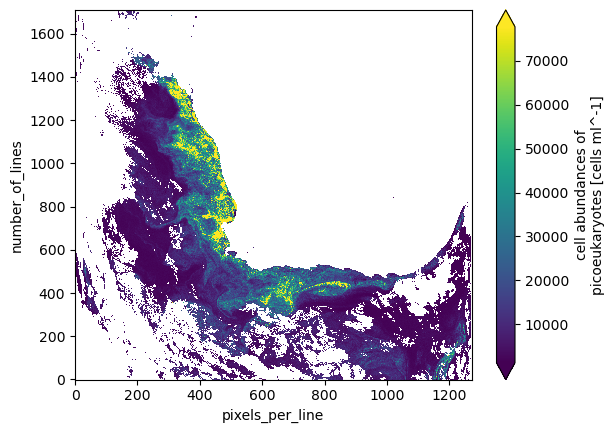

In [20]:
dataset = xr.open_dataset(par["ofile"], group="geophysical_data")
artist = dataset["picoeuk_moana"].plot(cmap="viridis", robust=True)

## 5. Composite L2 Data with `l2bin`

It can be useful to merge adjacent scenes to create a single, larger image. Let's do it with a chlorophyll product. 

Searching on a location defined as a line, rather than a point, is a good way to get granules that are
adjacent to eachother. Pass a list of latitude and longitude tuples to the `line` argument of `search_data`.

In [21]:
tspan = ("2024-04-27", "2024-04-27")
location = [(-56.5, 49.8), (-55.0, 49.8)]

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    line=location,
)

for item in results:
    display(item)

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 58.58321, 'Longitude': -16.05322}, {'Latitude': 51.69471, 'Longitude': -57.64384}, {'Latitude': 35.21958, 'Longitude': -45.93969}, {'Latitude': 40.85643, 'Longitude': -15.91448}, {'Latitude': 58.58321, 'Longitude': -16.05322}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-04-27T14:38:34Z', 'EndingDateTime': '2024-04-27T14:43:33Z'}}
Size(MB): 12.255784034729004
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240427T143834.L2.OC_BGC.V2_0.NRT.nc']

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 58.62406, 'Longitude': -40.6249}, {'Latitude': 51.72844, 'Longitude': -82.27307}, {'Latitude': 35.24957, 'Longitude': -70.53802}, {'Latitude': 40.88827, 'Longitude': -40.49408}, {'Latitude': 58.62406, 'Longitude': -40.6249}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-04-27T16:16:54Z', 'EndingDateTime': '2024-04-27T16:21:53Z'}}
Size(MB): 13.920551300048828
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240427T161654.L2.OC_BGC.V2_0.NRT.nc']

In [22]:
paths = earthaccess.download(results, "data")

While we have the downloaded location stored in the list `paths`, write the list to a text file for future use.

In [23]:
paths = [str(i) for i in paths]
with open("l2bin_ifile.txt", "w") as file:
    file.write("\n".join(paths))

The OCSSW program that performs merging, also known as "compositing" of remote sensing images, is called `l2bin`. Take a look at the program's options.

In [24]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2bin help

l2bin 7.0.7 (Jul 17 2024 13:15:06)


7.0.7


Usage: l2bin argument-list


  The argument-list is a set of keyword=value pairs. The arguments can


  be specified on the commandline, or put into a parameter file, or the


  two methods can be used together, with commandline over-riding.


  return value: 0=OK, 1=error, 110=north,south,east,west does not intersect


  file data.


The list of valid keywords follows:


   help (boolean) (alias=h) (default=false) = print usage information


   version (boolean) (default=false) = print the version


        information


   dump_options (boolean) (default=false) = print


        information about each option


   dump_options_paramfile (ofile) = print


        information about each option to paramfile


   dump_options_xmlfile (ofile) = print


        information about each option to XML file


   par (ifile) (alias=parfile) = input parameter file


   ifile (ifile) (alias=infile) = input L2 file name


   ofile (ofile) (default=output) = output file name


   fileuse (ofile) = write filenames of the input files used into this file


   suite (string) = suite for default parameters


   qual_prod (string) = quality product field name


   deflate (int) (default=5) = deflation level.  0=off or 1=low through 9=high


   verbose (boolean) (default=off) = Allow more verbose screen messages


   night (boolean) (default=off) = set to 1 for SST night processing


   qual_max (int) (default=2) = maximum acceptable quality


   rowgroup (int) (default=-1) = # of bin rows to process at once.


   sday (int) (default=1970001) = start datadate (YYYYDDD) [ignored for "regional" prodtype]


   eday (int) (default=2038018) = end datadate (YYYYDDD) [ignored for "regional" prodtype]


   latnorth (float) (default=90) = northern most latitude


   latsouth (float) (default=-90) = southern most latitude


   loneast (float) (default=0) = eastern most longitude


   lonwest (float) (default=0) = western most longitude


   minobs (int) (default=0) = required minimum number of observations


   delta_crossing_time (float) (default=0.0) = equator crossing time delta in


         minutes


         Caveat...if zero, the sensor default equator crossing time will be used


         This is not necessarily noon


   resolution (string) (alias=resolve) (default=H) = bin resolution


         H: 0.5km


         Q: 250m


        HQ: 100m


        HH: 50m


         1: 1.1km


         2: 2.3km


         4: 4.6km


         9: 9.2km


        18: 18.5km


        36: 36km


        1D: 1 degree


        HD: 0.5 degree


        QD: 0.25 degree


   prodtype (string) (default=day) = product type (Set to "regional" to bin all scans.)


   pversion (string) (default=unspecified) = production version


   composite_scheme (string) = composite scheme (min/max)


   composite_prod (string) = composite product fieldname


   flaguse (string) (default=ATMFAIL,LAND,HILT,HISATZEN,STRAYLIGHT,CLDICE,COCCOLITH,LOWLW,CHLFAIL,CHLWARN,NAVWARN,ABSAER,MAXAERITER,ATMWARN,HISOLZEN,NAVFAIL,FILTER) = flags masked [see /SENSOR/l2bin_defaults.par]


   l3bprod (string) (default=ALL) = l3bprod = bin products [default=all products]


        Set to "ALL" or "all" for all L2 products in 1st input file.


        Use ':' or ',' or ' ' as delimiters.


        Use ';' or '=' to delineate minimum values.


   area_weighting (int) (default=0) = Enable area weighting


        0: off


        1: pixel box


        2: pixel bounding box


        3: pixel polygon


   output_wavelengths (string) (default=ALL) = comma separated list of


        wavelengths for multi-wavelength products


   doi (string) = Digital Object Identifier (DOI) string


   oprodname (string) = comma separated list of output L3 product names.


        This option allows the user to specify the output product names which differ from the original l2 product names.


        Usage: original_l2_name:output_l3_name, i.e. oprodname=cloud_flag:cloud_fraction


Write a parameter file with the previously saved list of Level-2 BGC files standing in
for the usual "ifile" value. We can leave the datetime out of the "ofile" name rather than extracing a
time period from the granules chosen for binning.

In [25]:
ofile = "data/PACE_OCI.L3B.nc"
par = {
    "ifile": "l2bin_ifile.txt",
    "ofile": ofile,
    "prodtype": "regional",
    "resolution": 9,
    "flaguse": "NONE",
    "rowgroup": 2000,
}
write_par("l2bin.par", par)

In [26]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2bin par=l2bin.par

l2bin 7.0.7 (Jul 17 2024 13:15:06)


Loading default parameters from /opt/ocssw/share/common/l2bin_defaults.par


Loading default parameters from /opt/ocssw/share/oci/l2bin_defaults.par


Loading command line parameters


2 input files


Resolution: 9


Max Qual Allowed: 255


total number of bins: 5940422


Input row_group: 2000   Actual row_group: 1080


krow:     0 out of   2160  (-90.00 to   0.00) Sun Aug  4 03:51:19 2024


krow:  1080 out of   2160  (  0.00 to  90.00) Sun Aug  4 03:51:19 2024


# bins in row group : 2970211


# filled bins       :   29249


total_filled_bins: 29249


In [27]:
dataset = xr.open_dataset(par["ofile"], group="level-3_binned_data")
dataset

<xarray.Dataset> Size: 2MB
Dimensions:           (binListDim: 29249, binDataDim: 29249, binIndexDim: 2160)
Dimensions without coordinates: binListDim, binDataDim, binIndexDim
Data variables:
    BinList           (binListDim) {'names': ['bin_num', 'nobs', 'nscenes', 'weights', 'time_rec'], 'formats': ['<u4', '<i2', '<i2', '<f4', '<f4'], 'offsets': [0, 4, 6, 8, 12], 'itemsize': 16, 'aligned': True} 468kB ...
    chlor_a           (binDataDim) {'names': ['sum', 'sum_squared'], 'formats': ['<f4', '<f4'], 'offsets': [0, 4], 'itemsize': 8, 'aligned': True} 234kB ...
    carbon_phyto      (binDataDim) {'names': ['sum', 'sum_squared'], 'formats': ['<f4', '<f4'], 'offsets': [0, 4], 'itemsize': 8, 'aligned': True} 234kB ...
    poc               (binDataDim) {'names': ['sum', 'sum_squared'], 'formats': ['<f4', '<f4'], 'offsets': [0, 4], 'itemsize': 8, 'aligned': True} 234kB ...
    chlor_a_unc       (binDataDim) {'names': ['sum', 'sum_squared'], 'formats': ['<f4', '<f4'], 'offsets': [0, 4], 'itemsize': 8, 'aligned': True} 234kB ...
    carbon_phyto_unc  (binDataDim) {'names': ['sum', 'sum_squared'], 'formats': ['<f4', '<f4'], 'offsets': [0, 4], 'itemsize': 8, 'aligned': True} 234kB ...
    BinIndex          (binIndexDim) {'names': ['start_num', 'begin', 'extent', 'max'], 'formats': ['<u4', '<u4', '<u4', '<u4'], 'offsets': [0, 4, 8, 12], 'itemsize': 16, 'aligned': True} 35kB ...

[back to top](#Contents)

## 5. Make a Map from Binned Data with `l3mapgen`

The `l3mapgen` function of OCSSW allows you to create maps with a wide array of options you can see below:

In [28]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l3mapgen help

l3mapgen 2.4.0-V2024.1 (Jul 17 2024 13:14:38)


Usage: l3mapgen argument-list


  This program takes a product (or products if netCDF output) from an L3 bin


  or SMI file, reprojects the data using proj.4 and writes a mapped file in


  the requested output format.


  Return values


    0 = All Good


    1 = Error


    110 = No valid data to map


  The argument list is a set of keyword=value pairs.  Arguments can


  be specified on the command line, or put into a parameter file, or the


  two methods can be used together, with command line overriding.


The list of valid keywords follows:


   help (boolean) (alias=h) (default=false) = print usage information


   version (boolean) (default=false) = print the version


        information


   dump_options (boolean) (default=false) = print


        information about each option


   dump_options_paramfile (ofile) = print


        information about each option to paramfile


   dump_options_xmlfile (ofile) = print


        information about each option to XML file


   par (ifile) = input parameter file


   suite (string) = suite for default parameters


   ifile (ifile) = input L3 bin filename


   ofile (ofile) (default=output) = output filename


   oformat (string) (default=netcdf4) = output file format


        netcdf4: netCDF4 file, can contain more than one product


        hdf4:    HDF4 file (old SMI format)


        png:     PNG image file


        ppm:     PPM image file


        tiff:    TIFF file with georeference tags


   ofile_product_tag (string) (default=PRODUCT) = sub-string in ofile name that will be substituted by the product name


   ofile2 (ofile) = second output filename


   oformat2 (string) (default=png) = second output file format


        same options as oformat


   deflate (int) (default=4) = netCDF4 deflation level


   product (string) = comma separated list of products.


        Each product can have an optional colon and modifier appended.


        For example, "product=chlor_a,chlor_a:stdev,Kd_490:nobs"


        Available modifiers:


            avg       average value (default)


            stdev     standard deviation


            var       variance


            nobs      number of observations in the bin


            nscenes   number of contributing scenes


            obs_time  average observation time (TAI93)


            bin_num   bin ID number


   wavelength_3d (string) = comma separated list of wavelengths for 3D products


   resolution (string) = size of output pixel (default from input file)


        in meters or SMI dimensions


        90km: 432 x 216 image for full globe


        36km: 1080 x 540


        18km: 2160 x 1080


         9km: 4320 x 2160


         4km: 8640 x 4320


         2km: 17280 x 8640


         1km: 34560 x 17280


         hkm: 69120 x 34560


         qkm: 138240 x 69120


         smi: 4096 x 2048


        smi4: 8192 x 4096


        land: 8640 x 4320


         #.#:  width of a pixel in meters


       #.#km:  width of a pixel in kilometers


      #.#deg:  width of a pixel in degrees


   width (int) = width of output image in pixels; supercedes resolution parameter.


   projection (string) (default=platecarree) = proj.4 projection string or one


        of the following predefined projections:


        smi:       Standard Mapped image, cylindrical projection,


                   uses central_meridian.  NSEW defaults to whole globe.


                   projection="+proj=eqc +lon_0=<central_meridian>"


        platecarree: Plate Carree image, cylindrical projection,


                   uses central_meridian.


                   projection="+proj=eqc +lon_0=<central_meridian>"


        mollweide: Mollweide projection


                   projection="+proj=moll +lon_0=<central_meridian>"


        lambert:   Lambert conformal conic (2SP) projection


                   projection="+proj=lcc +lon_0=<central_meridian>


                                +lat_0=<scene center latitude>


                                +lat_1=<scene south latitude>


                                +lat_2=<scene north latitude>"


        albersconic: Albers Equal Area Conic projection


                   projection="+proj=aea +lon_0=<central_meridian>


                                +lat_0=<scene center latitude>


                                +lat_1=<scene south latitude>


                                +lat_2=<scene north latitude>"


        aeqd:      Azimuthal Equidistant projection


                   projection="+proj=aeqd +lon_0=<central_meridian>


                                +lat_0=<scene center latitude>"


        mercator:  Mercator cylindrical map projection


                   projection="+proj=merc +lon_0=<central_meridian>"


        transmerc:  Transverse Mercator cylindrical map projection


                   projection="+proj=tmerc +lon_0=<central_meridian>


                                +lat_0=<scene center latitude>"


        utm:  Universal Transverse Mercator cylindrical map projection


                   projection="+proj=utm +zone=<utm_zone> [+south]"


        obliquemerc:  Oblique Mercator cylindrical map projection


                   projection="+proj=omerc +gamma=0 +lat_0=<lat_0>


                          +lonc=<central_meridian> +alpha=<azimuth>


                          +k_0=1 +x_0=0 +y_0=0"


        ease2:     EASE-Grid 2.0 projection


                   projection="EPSG:6933"


        ortho:     Orthographic projection


                   projection="+proj=ortho +lat_0=<lat_0> +lon_0=<central_meridian>


                          +ellps=GRS80 +units=m"


        stere:     Stereographic projection


                   projection="+proj=stere +lat_0=<lat_0> +lat_ts=<lat_ts>


                          +lon_0=<central_meridian>


                          +ellps=WGS84 +datum=WGS84 +units=m"


        conus:     USA Contiguous Albers Equal Area Conic USGS version


                   projection="+proj=aea +lat_1=29.5 +lat_2=45.5


                         +lat_0=23.0 +lon_0=-96 +x_0=0 +y_0=0


                         +ellps=GRS80 +datum=NAD83 +units=m"


        alaska:    Alaskan Albers Equal Area Conic USGS version


                   projection="EPSG:3338"


        gibs:      latitudinally dependent projection


                   Plate Carree between 60S and 60N


                   else use Polar Sterographic


                   North Polar: projection="EPSG:3413"


                   South Polar: projection="EPSG:3031"


         raw:       Raw dump of bin file contents.


   write_projtext (boolean) (default=no) = write projection information to a text file.


   central_meridian (float) (default=-999) = central meridian for projection in deg east.


        Used only for raw dump and predefined projections as above.


   lat_ts (float) = latitude of true scale for projection in deg north.


        Used only for predefined projections above as required.


   lat_0 (float) = latitude of origin for projection in deg north.


        Used only for predefined projections above as required.


   lat_1 (float) = latitude of first standard parallel (south).


        Used only for predefined projections above as required.


   lat_2 (float) = latitude of second standard parallel (north).


        Used only for predefined projections above as required.


   azimuth (float) = projection rotation angle in deg north.


        Used only for predefined projections above as required.


   utm_zone (string) = UTM zone number.


        Used only for the UTM projection;


        Append 'S' for southern hemisphere zones (e.g. 59S).


   north (float) (default=-999) = Northernmost Latitude (default: file north)


   south (float) (default=-999) = Southernmost Latitude (default: file south)


   east (float) (default=-999) = Easternmost Longitude (default: file east)


   west (float) (default=-999) = Westernmost Longitude (default: file west)


   trimNSEW (boolean) (default=no) = should we trim output


        to match input NSEW range


   interp (string) (default=nearest) = interpolation method:


        nearest: use the value of the nearest bin for the pixel


        bin:     bin all of the pixels that intersect the area of the


                  output pixel


        area:    bin weighted by area of all the pixels that intersect


                  the area of the output pixel


   apply_pal (boolean) (default=yes) = apply color palette:


        yes: color image


         no: grayscale image


   palfile (ifile) = palette filename (default from product.xml)


   use_transparency (boolean) (default=no) = make missing data transparent (only valid for color PNG and TIFF)


   datamin (float) = minimum value for scaling (default from product.xml)


   datamax (float) = maximum value for scaling (default from product.xml)


   scale_type (string) = data scaling type (default from product.xml)


        linear:  linear scaling


        log:     logarithmic scaling


        arctan:  arc tangent scaling


   quiet (boolean) (default=false) = stop the status printing


   pversion (string) (default=Unspecified) = processing version string


   use_quality (boolean) (default=yes) = should we do quality factor processing


   quality_product (string) = product to use for quality factor processing


   use_rgb (boolean) (default=no) = should we use product_rgb to make a


        pseudo-true color image


   product_rgb (string) (default=rhos_670,rhos_555,rhos_412) = 


        Three products to use for RGB.  Default is sensor-specific.


   fudge (float) (default=1.0) = fudge factor used to modify size of L3 pixels


   threshold (float) (default=0) = minimum percentage of filled pixels before


        an image is generated


   num_cache (int) (default=500) = number of rows to cache in memory.


   mask_land (boolean) (default=no) = set land pixels to pixel value 254


   rgb_land (string) (default=160,82,45) = RGB value to use for land mask; comma separate string


   land (ifile) (default=$OCDATAROOT/common/landmask_GMT15ARC.nc) = land mask file


   full_latlon (boolean) (default=yes) = write full latitude and longitude arrays.


   doi (string) = Digital Object Identifier (DOI) string


Run `l3mapgen` to make a 9km map with a Plate Carree projection.

In [29]:
ifile = "data/PACE_OCI.L3B.nc"
ofile = ifile.replace(".L3B.", ".L3M.")
par = {
    "ifile": ifile,
    "ofile": ofile,
    "projection": "platecarree",
    "resolution": "9km",
    "interp": "bin",
    "use_quality": 0,
    "apply_pal": 0,
}
write_par("l3mapgen.par", par)

In [30]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l3mapgen par=l3mapgen.par

Loading default parameters from /opt/ocssw/share/oci/l3mapgen_defaults.par


l3mapgen 2.4.0-V2024.1 (Jul 17 2024 13:14:38)


ifile      : data/PACE_OCI.L3B.nc


ofile      : data/PACE_OCI.L3M.nc


oformat    : netcdf4


projection : platecarree


resolution : 9276.624m


product    : chlor_a,carbon_phyto,poc,chlor_a_unc,carbon_phyto_unc


north      :   57.708


south      :   35.458


east       :  -15.967


west       :  -72.537


image size : 269 x 681


99% complete


actual data min       : 0.001000


actual data max       : 1996.799805


num filled pixels     : 48565


percent filled pixels : 26.51%


Open the output with XArray, note that there is no group anymore and that `lat` and `lon` are coordinates as well as indexes.

In [31]:
dataset = xr.open_dataset(par["ofile"])
dataset

<xarray.Dataset> Size: 4MB
Dimensions:           (lat: 269, lon: 681, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat               (lat) float32 1kB 57.67 57.58 57.5 ... 35.67 35.58 35.5
  * lon               (lon) float32 3kB -72.49 -72.41 -72.33 ... -16.09 -16.01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a           (lat, lon) float32 733kB ...
    carbon_phyto      (lat, lon) float32 733kB ...
    poc               (lat, lon) float32 733kB ...
    chlor_a_unc       (lat, lon) float32 733kB ...
    carbon_phyto_unc  (lat, lon) float32 733kB ...
    palette           (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/61)
    product_name:                     PACE_OCI.L3M.nc
    instrument:                       OCI
    title:                            OCI Level-3 Equidistant Cylindrical Map...
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         PACE
    source:                           satellite observations from OCI-PACE
    ...                               ...
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    proj4_string:                     +proj=eqc +lat_ts=0 +lat_0=0 +x_0=0 +y_...
    data_bins:                        48565
    data_minimum:                     0.0009999998
    data_maximum:                     1996.7998

Now that we have projected chlorophyll data, we can make a map with coastines and gridlines provided by Cartopy. The `projection` argument to `plt.axes` indicates the projection we want to have in the visualization. The `transform`
argument in the `Dataset.plot` call indicates the projection the data are in. Cartopy does reprojection easilly
between two projected coordinate reference systems.

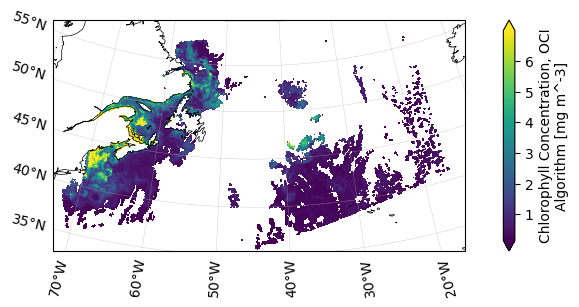

In [32]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.AlbersEqualArea(-45))
artist = dataset["chlor_a"].plot(x="lon", y="lat", cmap="viridis", robust=True, ax=ax, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.2)
ax.coastlines(linewidth=0.5)
plt.show()

[back to top](#Contents)